Fig. 6: CellRank predicts a novel de-differentiation trajectory in murine lung regeneration 
----
Applly CellRank to a time-series dataset of lung epithelial cells past bleomycin injury, see [Strunz et al., Nature Communications 2020](https://www.nature.com/articles/s41467-020-17358-3).

# Preliminaries

## Import packages

In [1]:
# import standard packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# import single-cell packages
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [2]:
cr.logging.print_versions()

cellrank==1.5.0+g65f1562 scanpy==1.8.1 anndata==0.7.6 numpy==1.20.3 numba==0.54.0 scipy==1.7.1 pandas==1.3.3 pygpcca==1.0.2 scikit-learn==0.24.2 statsmodels==0.13.0rc0 python-igraph==0.9.1 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.4.3 seaborn==0.11.2


In [3]:
cr.logging.print_version_and_date()

Running CellRank 1.5.0+g65f1562, on 2021-10-26 14:54.


## Set up paths

Define the paths to load data, cache results and write figure panels.

In [4]:
sys.path.insert(0, "../..")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, CACHE_DIR, FIG_DIR

Set up the paths to save figures.

In [5]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Set up caching

Note: we use a caching extension called `scachepy` for this analysis, see [here](https://github.com/theislab/scachepy). We do this to speed up the runtime of this notebook by avoiding the most expensive computations. Below, we check whether you have scachepy installed and if you don't, then we automatically recompute all results. 

In [6]:
try:
    import scachepy
    c = scachepy.Cache(CACHE_DIR / "lung", separate_dirs=True)
    print('Sucessfully imported scachepy. Expensive computations will be cached. ')
except ImportError:
    c = None
    print('Failed to import scachepy. Consider installing it from `https://github.com/theislab/scachepy`. ')
use_caching = c is not None
c

Sucessfully imported scachepy. Expensive computations will be cached. 


Cache(root=/Users/marius/Projects/cellrank_reproducibility_2/cache/lung, ext='.pickle', compression='None')

## Set global parameters

Set some plotting parameters.

In [7]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

Set other global parameters

In [8]:
# should figures just be displayed or also saved?
save_figure = True

# should cashed values be used, or recompute?
force_recompute = False

Transition matrix parameters

In [9]:
# set the parameters we want to use to compute the transition matrix
weight_connectivities=0.2
mode="stochastic" 
n_jobs=8
softmax_scale=None

## Define utility functions

Utility funciton to create a set of categorical colors. 

In [10]:
from typing import Optional, Iterable, TypeVar, Tuple
from matplotlib import cm as cm
from cellrank.tl._colors import _convert_to_hex_colors

AnnData = TypeVar("AnnData")

Utility funnction to create a set of categorical colors

In [11]:
def _create_categorical_colors(n_categories: Optional[int] = None):
    cmaps = [cm.tab10, cm.Pastel1]
    max_cats = sum(c.N for c in cmaps)

    if n_categories is None:
        n_categories = max_cats
    if n_categories > max_cats:
        raise ValueError(
            f"Maximum number of colors ({max_cats}) exceeded: `{n_categories}`."
        )

    colors = []
    for cmap in cmaps:
        colors += [cmap(i) for i in range(cmap.N)][: n_categories - len(colors)]
        if len(colors) == n_categories:
            return _convert_to_hex_colors(colors)

    raise RuntimeError(f"Unable to create `{n_categories}` colors.")

The following two functions are used to plot the frequencies of cell types per samples as a function of time. 

In [12]:
def _get_frequ(adata: AnnData, 
               cluster: str,
               obs_key: str, 
               obs_value: str,
               cluster_key: str = 'clusters'
              ):
    """Utility function to return frequencies. """
    mask = adata.obs[cluster_key] == cluster
    return 100*np.sum(adata[mask].obs[obs_key] == obs_value) / np.sum(adata.obs[obs_key] == obs_value)

In [13]:
def plot_frequency(adata: AnnData,
                   cluster_key: str = 'clusters',
                   sample_key: str = 'identifier',
                   time_key: str = 'day',
                   clusters: Iterable[str] = ['Basal'], 
                   relative_frequencies: bool = False,
                   label_size: int = 14,
                   tick_size: int = 16,
                   figsize: Tuple = (7, 3),
                   save: Optional[str] = None,
                   kwargs: Optional[dict] = {},
                  ):
    """Plot the frequency of cell types per sample as a function of time.
    
    Parameters
    --------
    cluster_key
        Key from `adata.obs` where cluster information can be retrieved.
    sample_key
        Key from `adata.obs` where sample information can be retrieved.
    time_key
        Key from `adata.obs` where time point information can be retrieved.
    clusters
        Subset of clusters that frequencies should be plotted for.
    relative_frequencies
        Whether to normalise frequencies by their maximum per cluster.
    label_size
        Label size for the plot.
    tick_size
        x and y tick size for the plot.
    figsize
        Size of the figure.
    save
        Path to save the plot.
    kwargs
        Keyworded arguments for `sns.lmplot`. 
        
    Returns
    --------
    Nothing, just plots.
    """
    
    # define a lookup table (sample_id <-> day)
    samples = adata.obs[sample_key].cat.categories
    lookup_dict = {sample: adata[adata.obs[sample_key] == sample].obs[time_key][0] 
                   for sample in samples}
    
    # Use a dict comprehension to fill in the values, iteratively calling `_get_frequ`
    frequ_dict = {sample: {cluster: _get_frequ(adata,
                                              cluster=cluster, 
                                              obs_key=sample_key, 
                                              obs_value=sample) 
                                     for cluster in clusters} 
                                     for sample in samples}
    
    # transform the dict into a dataframe that can be used for plotting
    frequ_df = pd.DataFrame.from_dict(frequ_dict, orient='index')

    # use the lookup dict to introduce a time_key column
    frequ_df[time_key] = 0
    for idf, row in frequ_df.iterrows():
        day = lookup_dict[idf]
        frequ_df.loc[idf, time_key] = day
    frequ_df[time_key] = np.array(frequ_df[time_key], dtype='int')
    
    # print information on the maximum frequency
    for cl in clusters:
        print(f"{cl}: max frequency is {frequ_df[cl].max():.1f}% at day "
              f"{frequ_df.iloc[frequ_df[cl].argmax()][time_key]}")
        
    # Transform this into relative frequencies by dividing each column by it's maximum value.
    if relative_frequencies:
        for ct in clusters:
            frequ_df[ct] /= frequ_df[ct].max()
    
    # Melt it down to get to long-form (easier to plot using seaborn)
    frequ_df = frequ_df.melt(id_vars=time_key, value_name='frequency', var_name=cluster_key)
    
    # plot using seaborn
    fg = sns.lmplot(x=time_key, 
                    y='frequency', 
                    hue=cluster_key, 
                    data=frequ_df, 
                    order=4, 
                    truncate=True, 
                    n_boot=100,
                    **kwargs)

    # prettify the plot
    fg.fig.set_size_inches(figsize)
    fg.set(xticks = np.unique(frequ_df.loc[:, time_key]))   
    fg.ax.set_xlabel(time_key, size = label_size)
    
    fg.ax.set_ylabel('frequency', size = label_size)
    fg.ax.tick_params(labelsize = tick_size)
    fg.ax.set_ylim([frequ_df['frequency'].min() - 0.1, frequ_df['frequency'].max() + 0.1])
    fg.ax.set_xlim([frequ_df[time_key].min() - 0.5, frequ_df[time_key].max() + 0.5])

    if save != None:
        plt.savefig(save)
    plt.show()

## Load the data

Load the AnnData object from the CellRank software package. 

In [14]:
adata = cr.datasets.lung(DATA_DIR / "lung" / "lung.h5ad")
adata

AnnData object with n_obs × n_vars = 24882 × 24051
    obs: 'initial_size', 'percent_mito', 'identifier', 'name', 'louvain', 'batch', 'day', 'clusters_coarse', 'clusters', 'early_vs_late'
    var: 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'highly_variable'
    uns: 'batch_colors', 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'diffmap_evals', 'early_vs_late_colors', 'louvain_colors', 'neighbors', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

Assign a colormap which assigned very distinct colors to the clusters we're going to zoom in on. 

In [15]:
adata.obs['clusters'].cat.reorder_categories(['Basal','Goblet','Club activated', 'MHC-II+ Club','Club','AT1', 'AT2',
                                              'Krt8+ ADI', 'AT2 activated', 'Ciliated activated', 'Ciliated', 
                                               'Neuroendocrine', 'Club to ciliated', 'Mki67+ proliferation'], inplace=True)
n_clusters = len(adata.obs['clusters'].cat.categories)
print(f"There are {n_clusters} clusters here. ")

# assign colors
clusters_colors = _create_categorical_colors(n_clusters)
adata.uns['clusters_colors'] = clusters_colors

There are 14 clusters here. 


## Pre-process the data

### Raw data (for plotting)

In [16]:
adata_raw = adata.copy()
sc.pp.filter_genes(adata_raw, min_cells=10)
scv.pp.normalize_per_cell(adata_raw)
sc.pp.log1p(adata_raw)

# annotate highly variable genes, but don't filter them out
sc.pp.highly_variable_genes(adata_raw)
print(f"This detected {np.sum(adata_raw.var['highly_variable'])} highly variable genes. ")
adata.raw = adata_raw

filtered out 7933 genes that are detected in less than 10 cells
Normalized count data: X, spliced, unspliced.
extracting highly variable genes
    finished (0:00:00)
This detected 1899 highly variable genes. 


### Data for velocity computation

In [17]:
# filter, normalise, log transform
scv.pp.filter_and_normalize(adata, min_shared_counts=20, log=True, n_top_genes=2000)

# compute KNN graph and scvelo's moments
sc.pp.neighbors(adata, n_neighbors=30)
scv.pp.moments(adata, n_neighbors=None)

Filtered out 18722 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    using 'X_pca' with n_pcs = 70
    finished (0:00:14)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# Compute scVelo velocities

## Visualize annotations

saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_lung/suppl_fig_annotations/umap_clusters.pdf


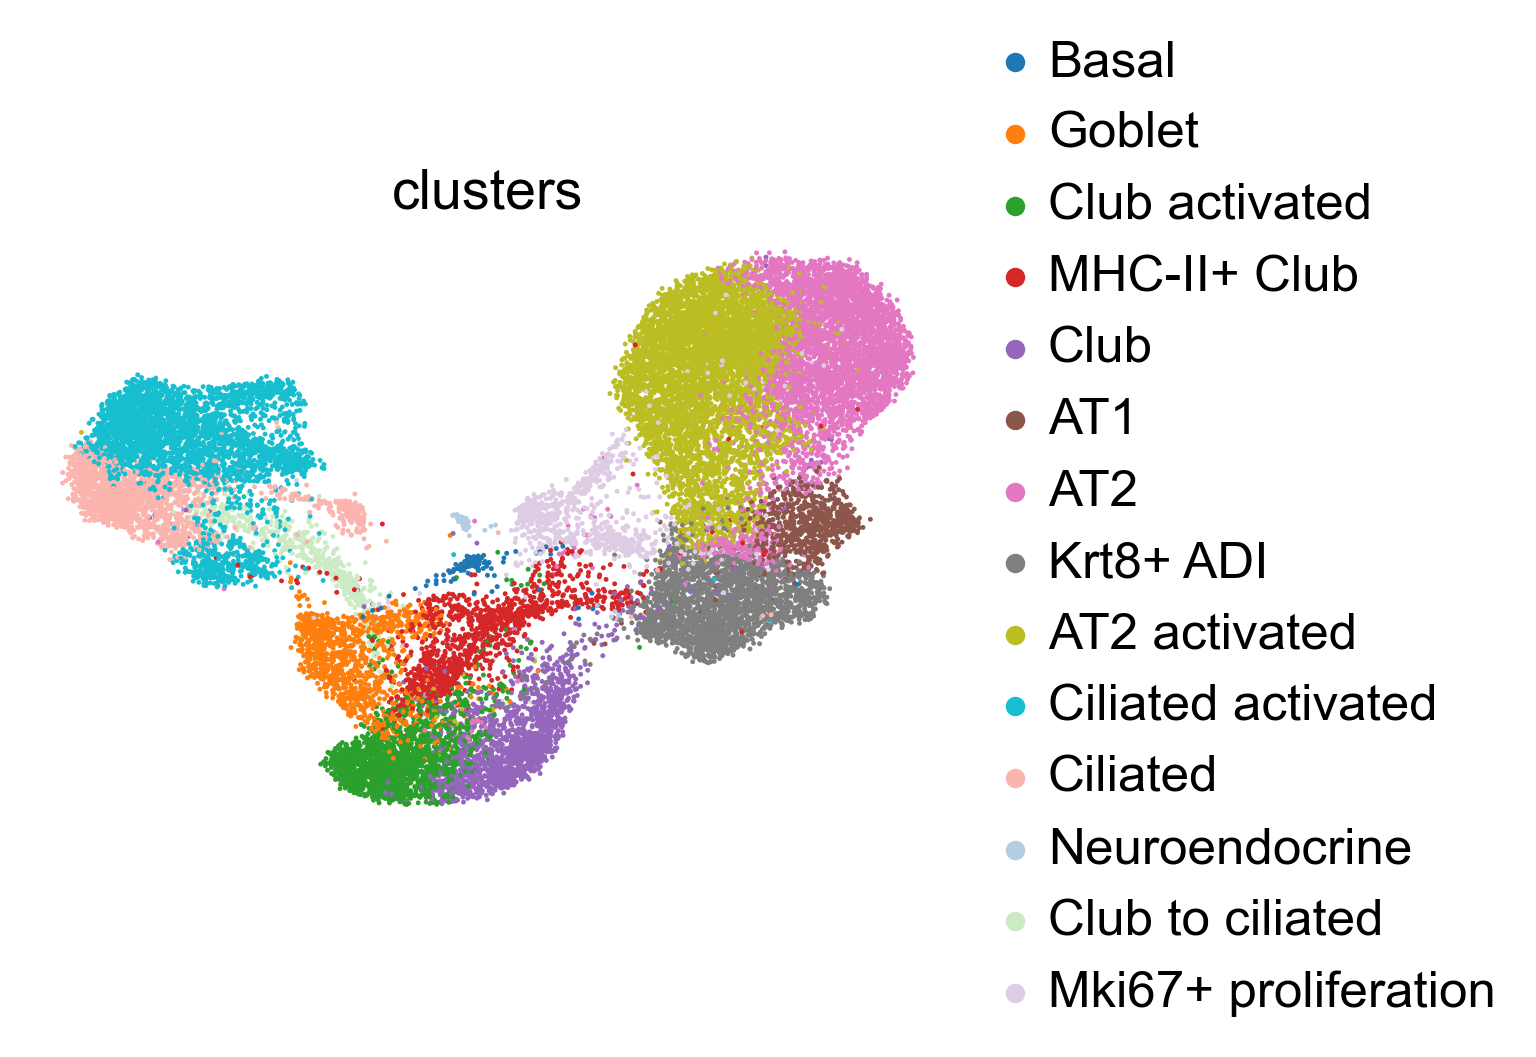

In [18]:
scv.pl.scatter(adata, legend_loc='right', dpi=100, 
               save=scv.settings.figdir + '/suppl_figures_lung/suppl_fig_annotations/umap_clusters.pdf' if save_figure else None)

saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_lung/suppl_fig_annotations/umap_day.pdf


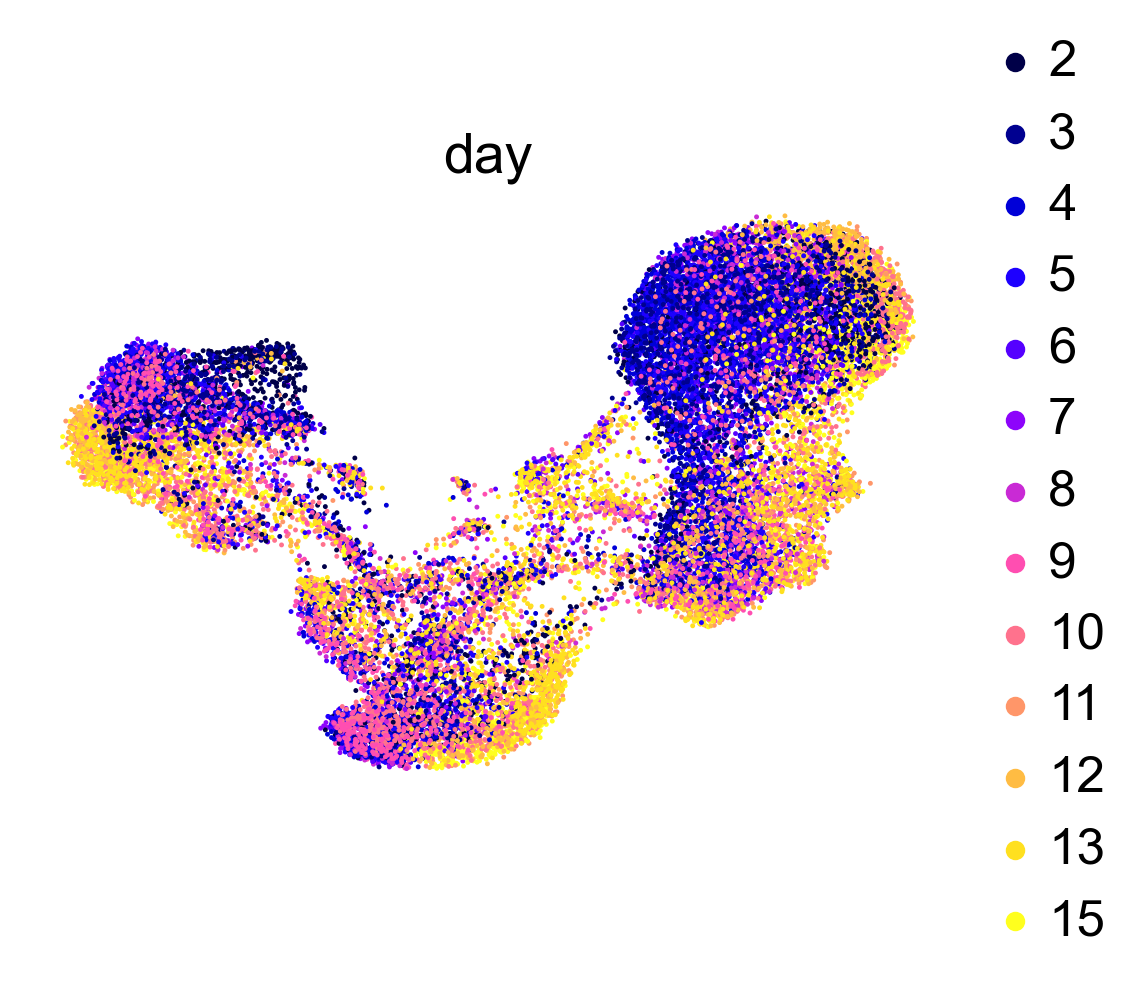

In [19]:
n_colors = len(adata.obs['day'].cat.categories)
adata.uns['day_colors'] = _convert_to_hex_colors(sns.color_palette("gnuplot2", n_colors=n_colors))
scv.pl.scatter(adata, c='day', legend_loc='right', dpi=100, 
              save=scv.settings.figdir + 'suppl_figures_lung/suppl_fig_annotations/umap_day.pdf' if save_figure else None)

Visualise some goblet cell markers

saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_lung/suppl_fig_annotations/umap_goblet_markers.pdf


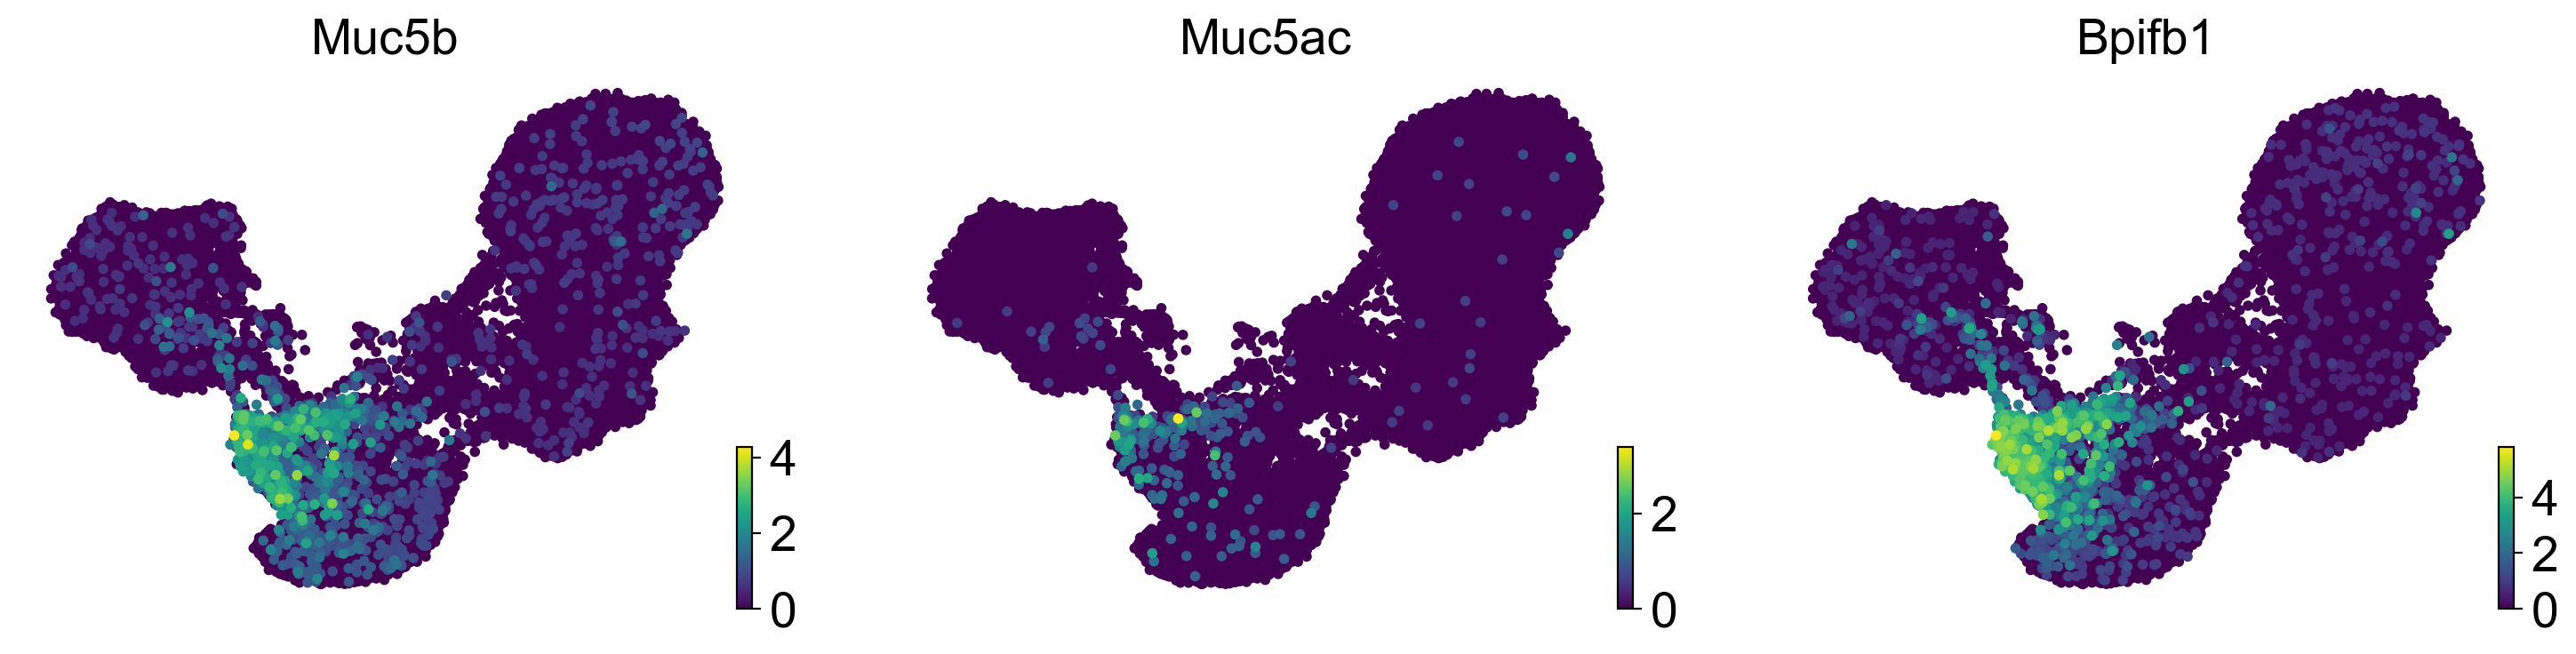

In [20]:
goblet_markers = ['Muc5b', 'Muc5ac', 'Bpifb1']
scv.pl.scatter(adata, legend_loc='right', c=goblet_markers, size=70, dpi=100,
              save=scv.settings.figdir +'suppl_figures_lung/suppl_fig_annotations/umap_goblet_markers.pdf' if save_figure else None)

## Compute velocities using scVelo

In [21]:
# compute/load from cache the dyn. model params and compute velocities
if use_caching:
    c.tl.recover_dynamics(adata, fname='2021-09-24_recover_dynamics', force=force_recompute, n_jobs=n_jobs)
else:
    scv.tl.recover_dynamics(adata)
    
scv.tl.velocity(adata, mode='dynamical', n_jobs=n_jobs)

Loading data from: `2021-09-24_recover_dynamics.pickle`.
`adata.var` already contains key: `'velocity_gamma'`.
computing velocities
    finished (0:00:16) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Project velocities onto the embedding

Compute the velocity graph and use it to project velocities onto the UMAP. 

computing velocity graph (using 8/8 cores)


  0%|          | 0/24882 [00:00<?, ?cells/s]

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:27) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:05) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
figure cannot be saved as pdf, using png instead.
saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/fig_6_lung/umap_velocities.png


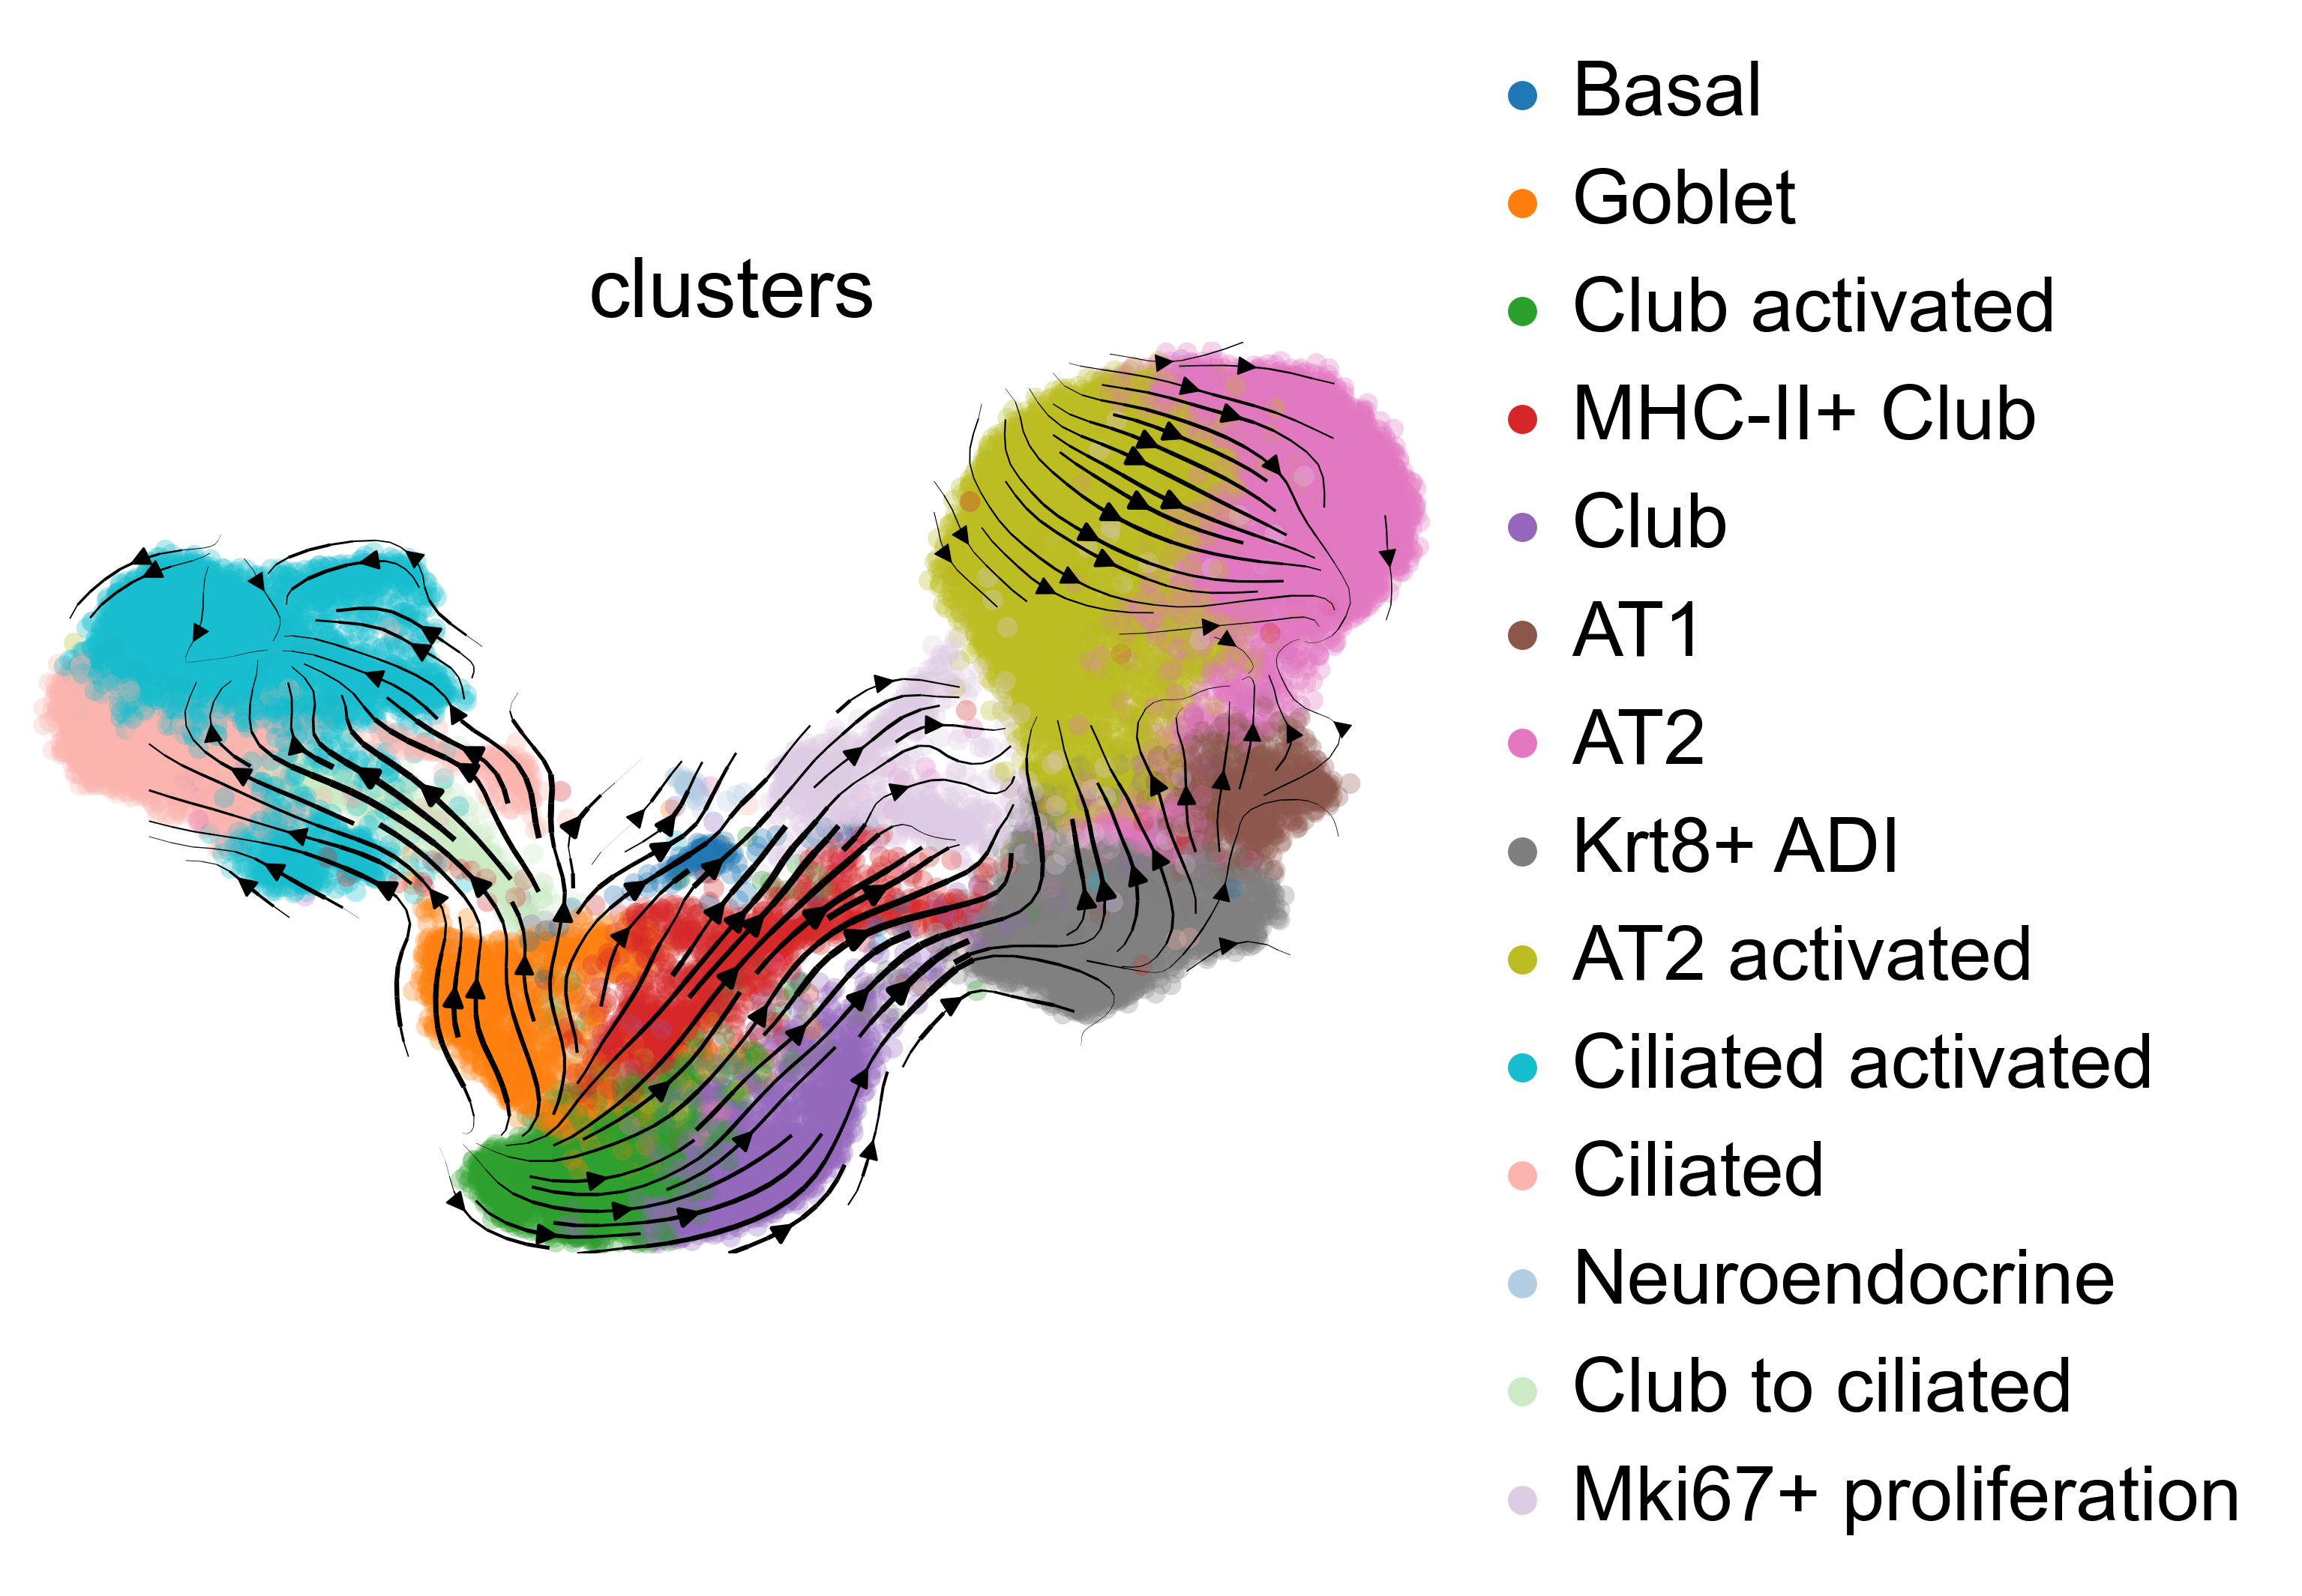

In [22]:
scv.tl.velocity_graph(adata, n_jobs=n_jobs)

airway_subset = ["Basal", "Goblet", "Club activated", "MHC-II+ Club", "Club"]
fig_kwargs = {'color': ['clusters'], 
              'legend_loc': 'right', 
              'dpi': 200}

if save_figure: fig_kwargs['save'] = scv.settings.figdir + 'fig_6_lung/umap_velocities.pdf'
scv.pl.velocity_embedding_stream(adata, **fig_kwargs)

# Apply CellRank to all cells

## Initialise kernel and estimator

This serves as an example of how to cach a transition matrix and of the default values we should be using. 

In [23]:
from cellrank.tl.estimators import GPCCA

if use_caching:
    c.tl.transition_matrix(adata, 
                           weight_connectivities=weight_connectivities, 
                           mode=mode, 
                           n_jobs=n_jobs, 
                           softmax_scale=softmax_scale, 
                           fname='2021-09-24_transition_matrix_stochastic', 
                           force=force_recompute)
    g_fwd = GPCCA(adata, obsp_key='T_fwd')
else:
    kernel = cr.tl.transition_matrix(adata, 
                                     weight_connectivities=weight_connectivities, 
                                     mode=mode, 
                                     n_jobs=n_jobs, 
                                     softmax_scale=softmax_scale)
    g_fwd = GPCCA(kernel)
    
print(g_fwd)

Loading data from: `2021-09-24_transition_matrix_stochastic.pickle`.
GPCCA[n=24882, kernel=<PrecomputedKernel[origin=adata.obsp['T_fwd']]>]


## Print transition matrix statistics for reproducibility

To make sure that we're using the same transition matrix, show some stats. 

In [24]:
# just for consistency, display some summary staes about the transition matrix
T = adata.obsp['T_fwd']
T_med, T_mean, T_var = np.median(T.data), np.mean(T.data), np.var(T.data)
T_min, T_max = np.min(T.data), np.max(T.data)

print(f'med = {T_med:.6f},\nmean = {T_mean:.6f},\nvar = {T_var:.6f},\nmin = {T_min:.6f},\nmax = {T_max:.6f}')

med = 0.014550,
mean = 0.018997,
var = 0.000268,
min = 0.000002,
max = 0.462522


## Compute the real Schur decomposition

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)


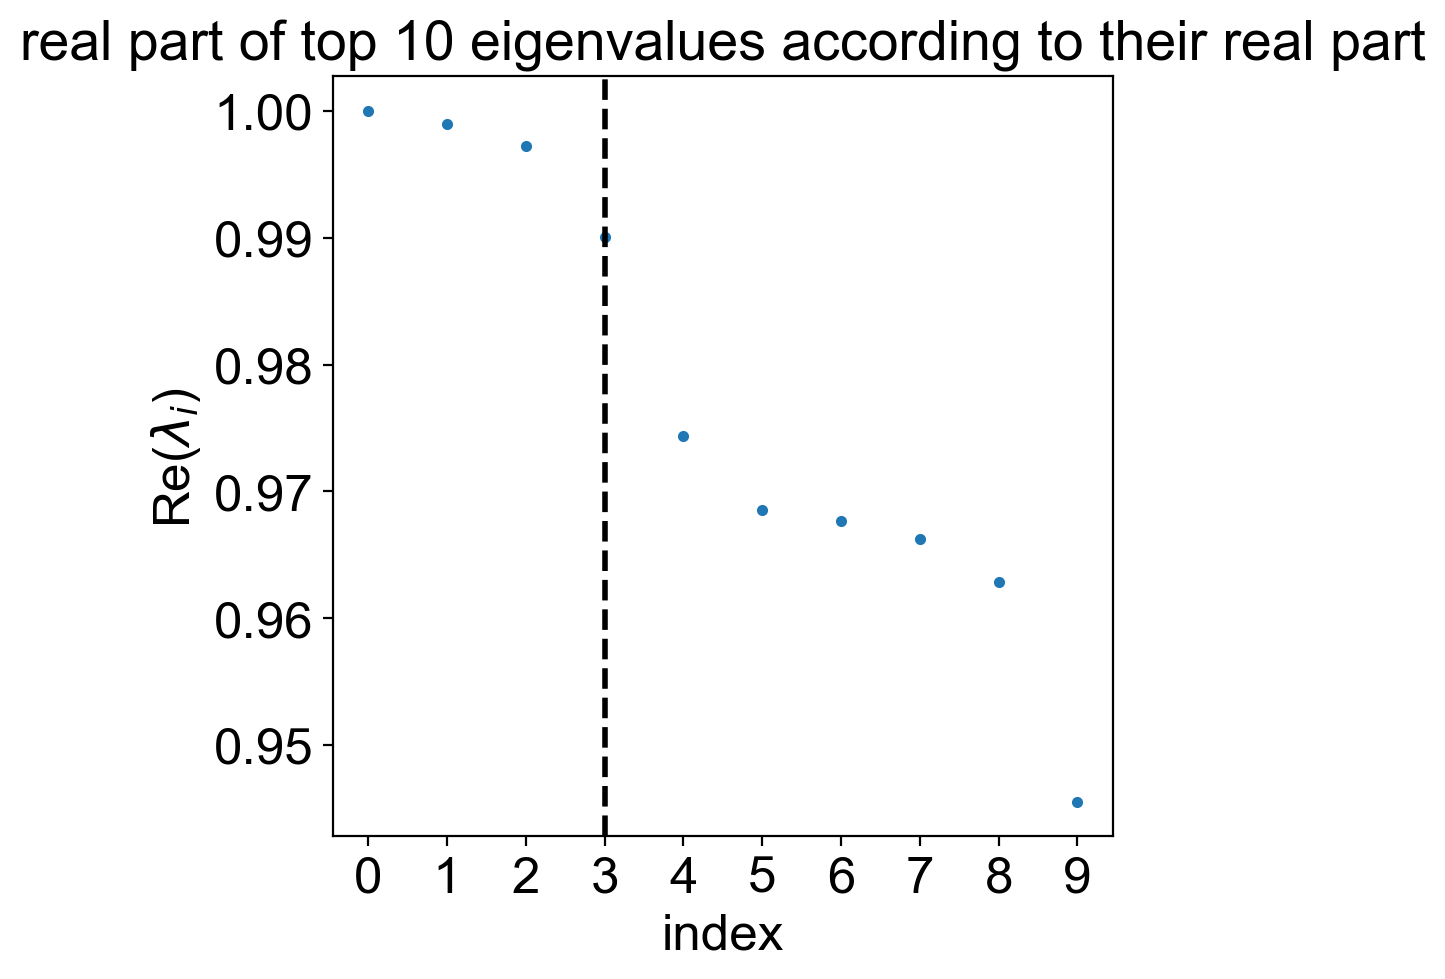

In [25]:
g_fwd.compute_schur()
g_fwd.plot_spectrum(real_only=True)

## Decompose into macrostates

Computing `9` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:08)
saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_lung/suppl_fig_club_to_ciliated/umap_macrostates.pdf


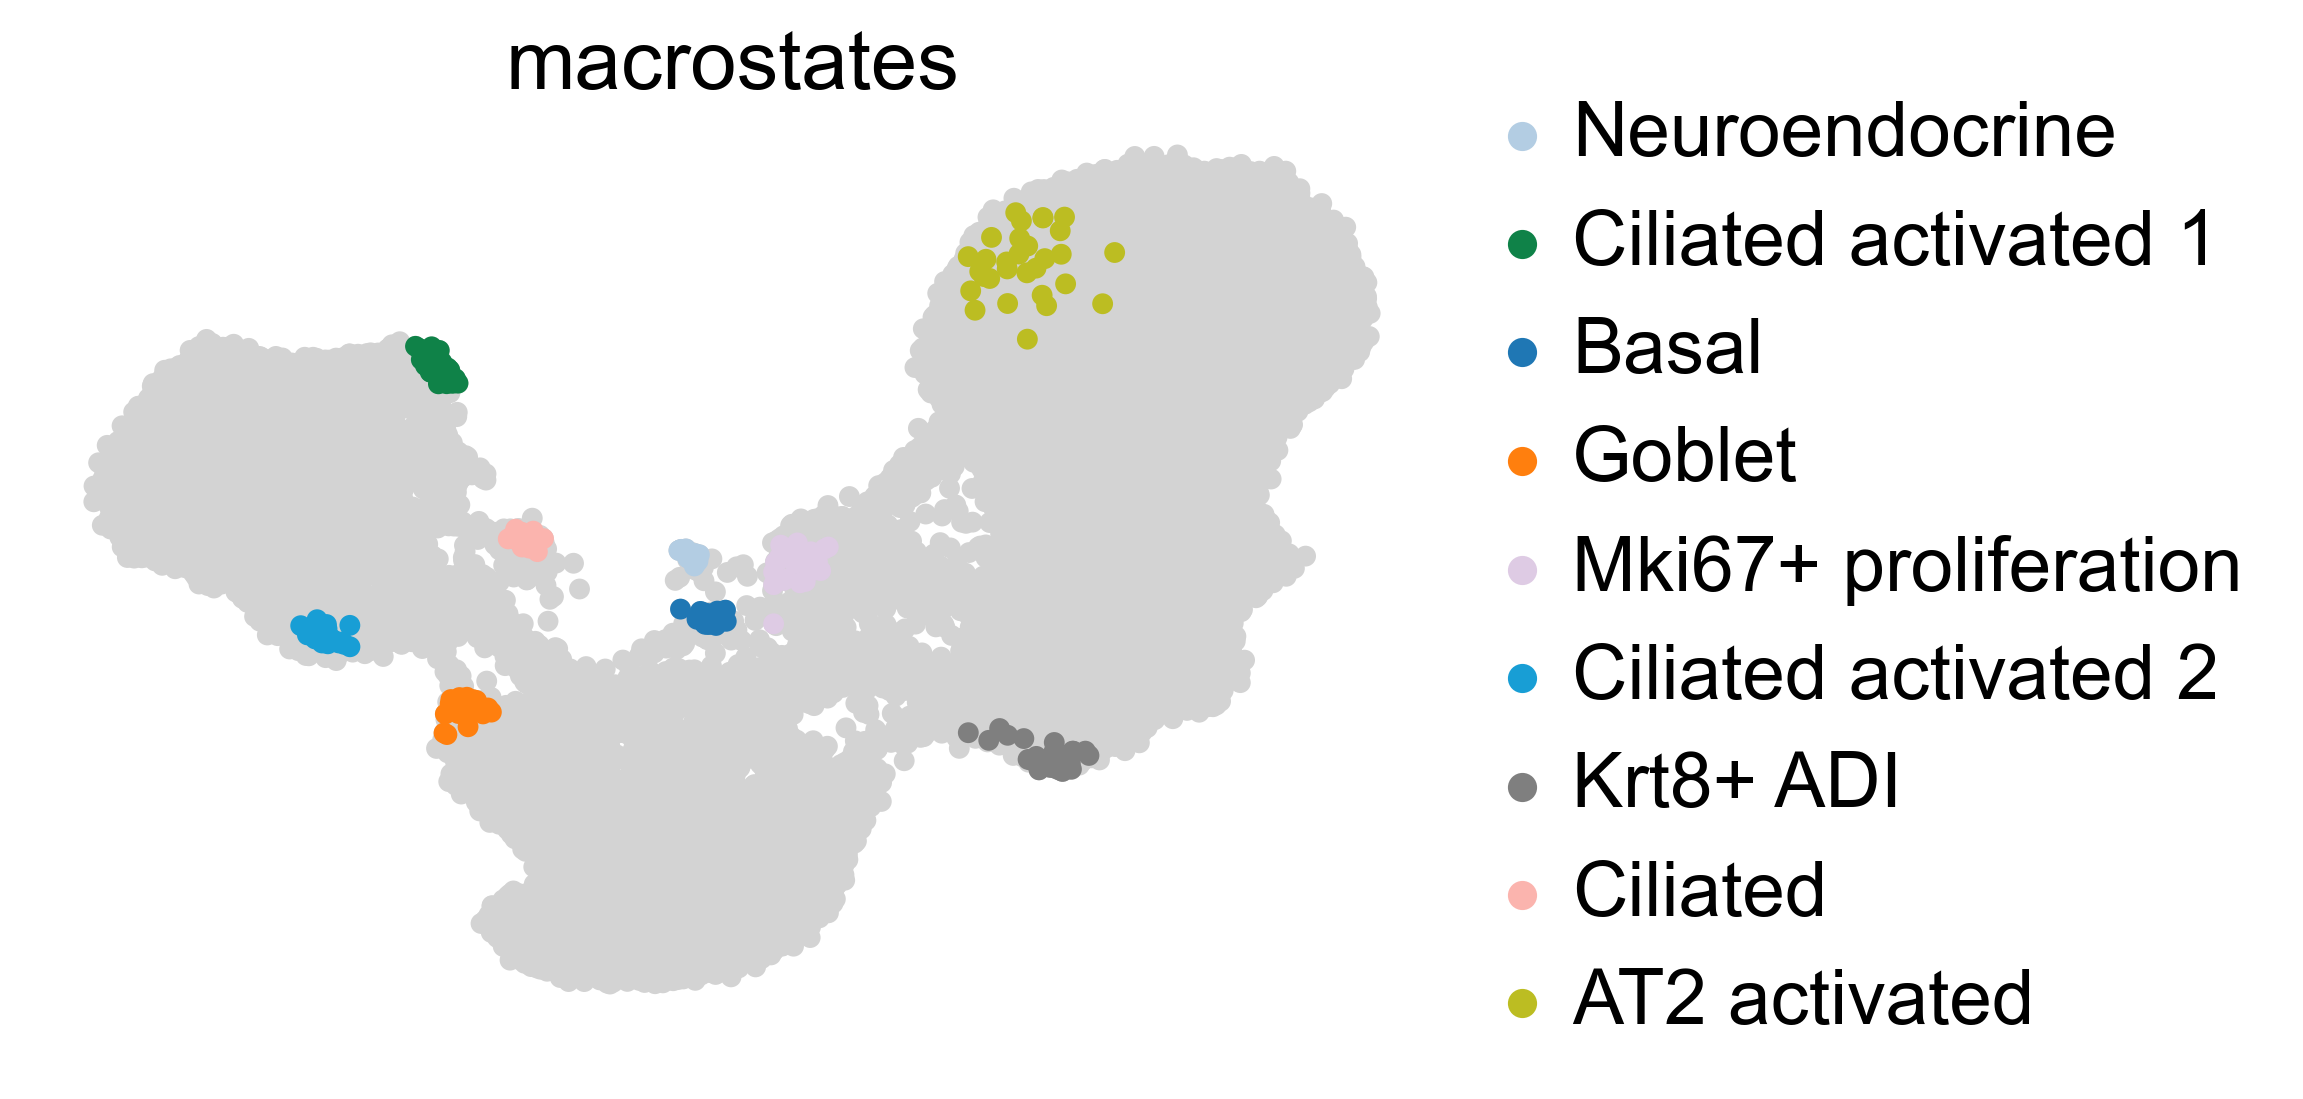

In [26]:
n_states = 9
g_fwd.compute_macrostates(cluster_key='clusters', n_states=n_states, n_cells=30)

g_fwd.plot_macrostates(legend_loc='right', dpi=150, discrete=True, size=100,
                       save=scv.settings.figdir + 'suppl_figures_lung/suppl_fig_club_to_ciliated/umap_macrostates.pdf' if save_figure else None)

## Compute fate probabilities towards these macrostates

We'll treat all identified macrostates as terminal states and compute fate probabilities towards them. 

In [27]:
g_fwd.set_terminal_states_from_macrostates()
g_fwd.compute_absorption_probabilities(solver='gmres', n_jobs=n_jobs)

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing absorption probabilities


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/9 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:03)


## Look into goblet -> basal

saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_lung/suppl_fig_goblet_to_basal/umap_fate_probs.pdf


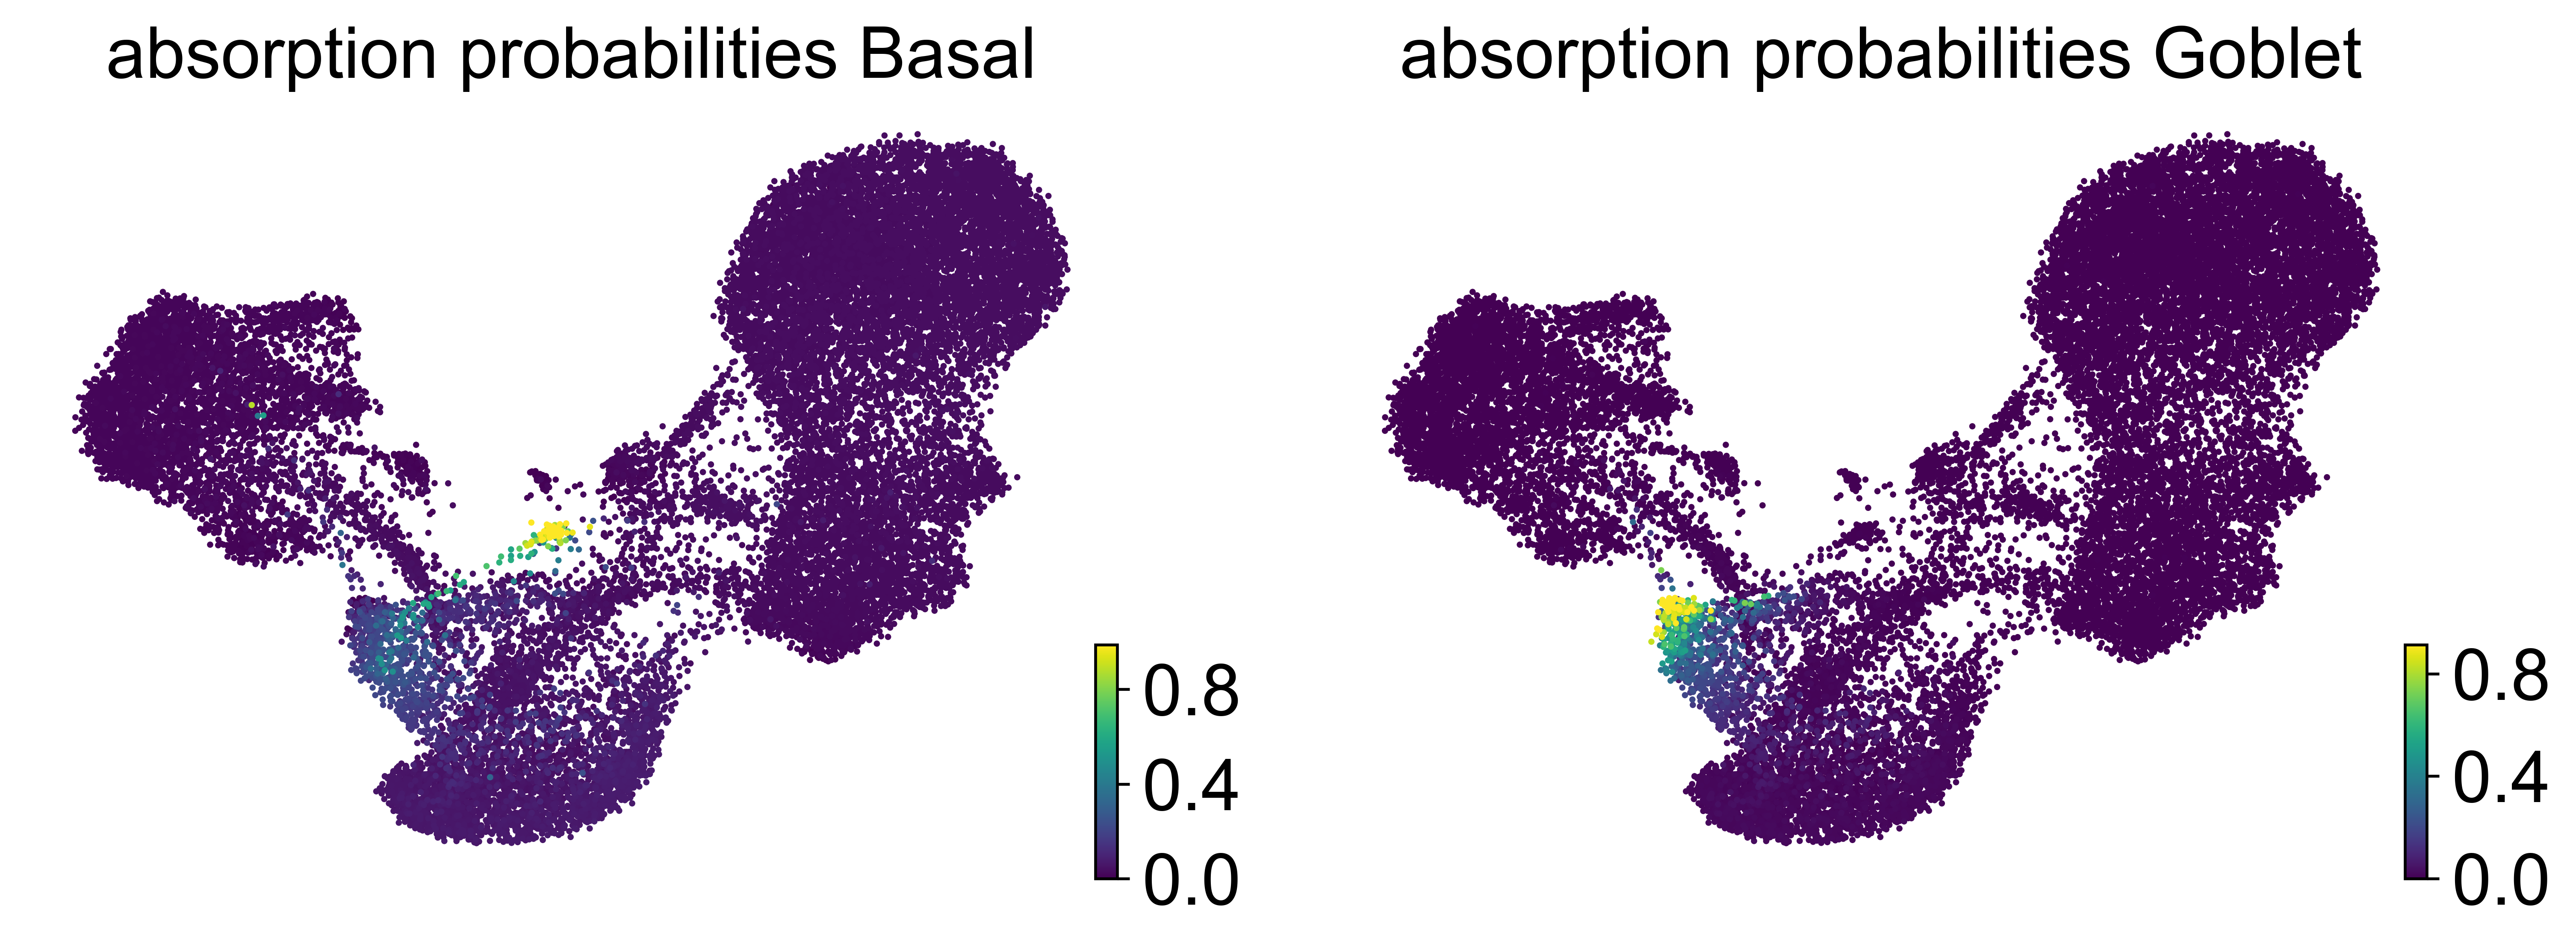

In [28]:
fig_kwargs = {'same_plot': False, 'dpi': 300, 'states': ['Basal', 'Goblet']}
if save_figure: fig_kwargs['save'] = scv.settings.figdir + 'suppl_figures_lung/suppl_fig_goblet_to_basal/umap_fate_probs.pdf'
g_fwd.plot_absorption_probabilities(**fig_kwargs)

Save these two in the obs annotations

In [29]:
adata.obs['basal_probability'] = adata.obsm['to_terminal_states']['Basal']
adata.obs['goblet_probability'] = adata.obsm['to_terminal_states']['Goblet']

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Show a heatmap of goblet -> basal and basal -> goblet probs

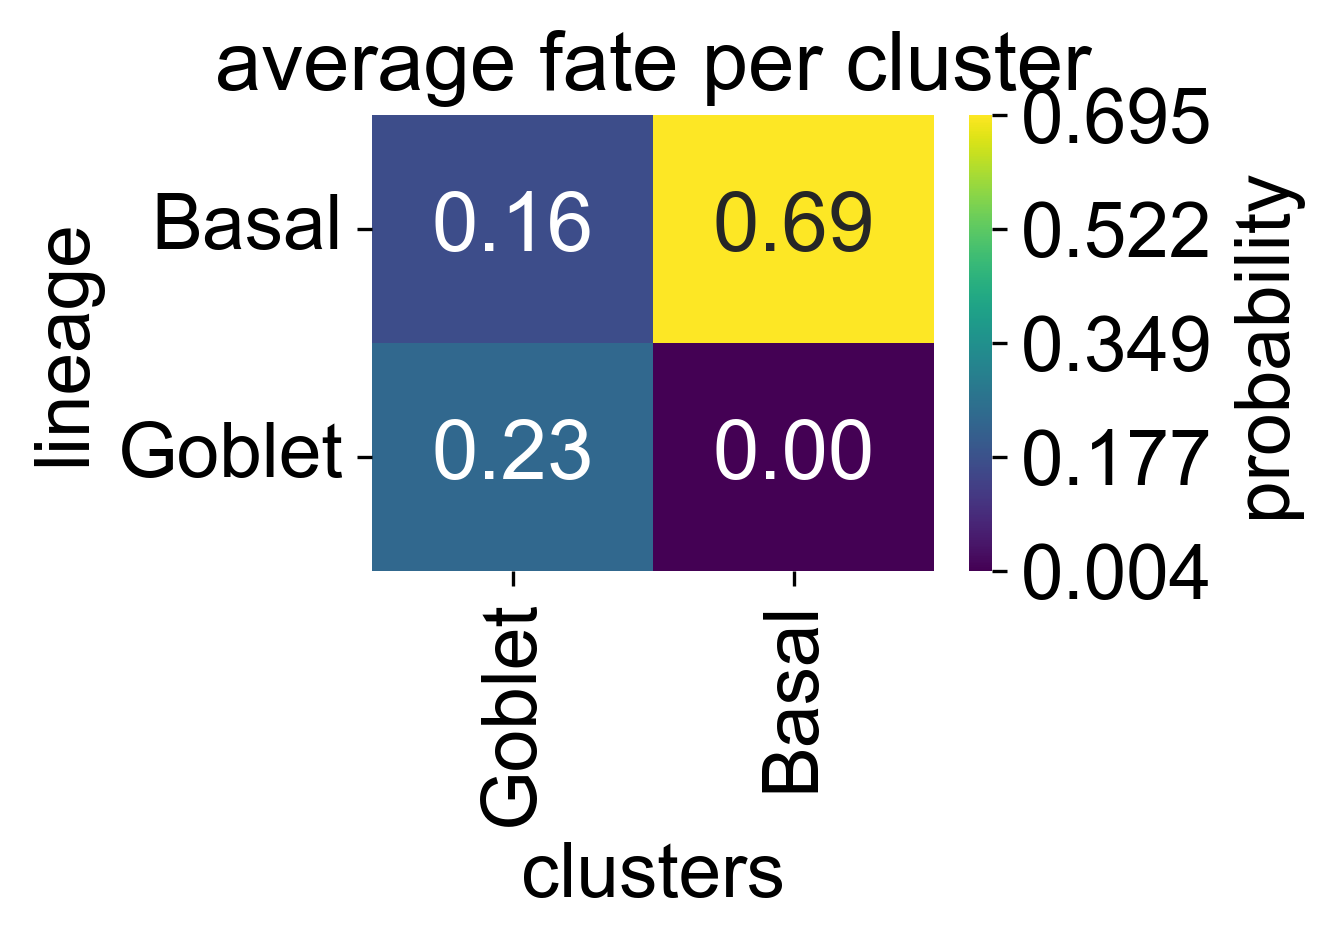

In [30]:
fig_kwargs = {'mode': 'heatmap', 'cluster_key': 'clusters', 'clusters': ['Goblet', 'Basal'], 
                 'lineages': ['Basal', 'Goblet'], 
                 'figsize':(3, 2), 
                 'dpi': 150}
if save_figure: fig_kwargs['save'] = scv.settings.figdir + 'suppl_figures_lung/suppl_fig_goblet_to_basal/heatmap_fate_probs.pdf'
cr.pl.cluster_fates(adata, **fig_kwargs)

## Plot cell-type frequencies by time point

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Basal: max frequency is 1.4% at day 15.0


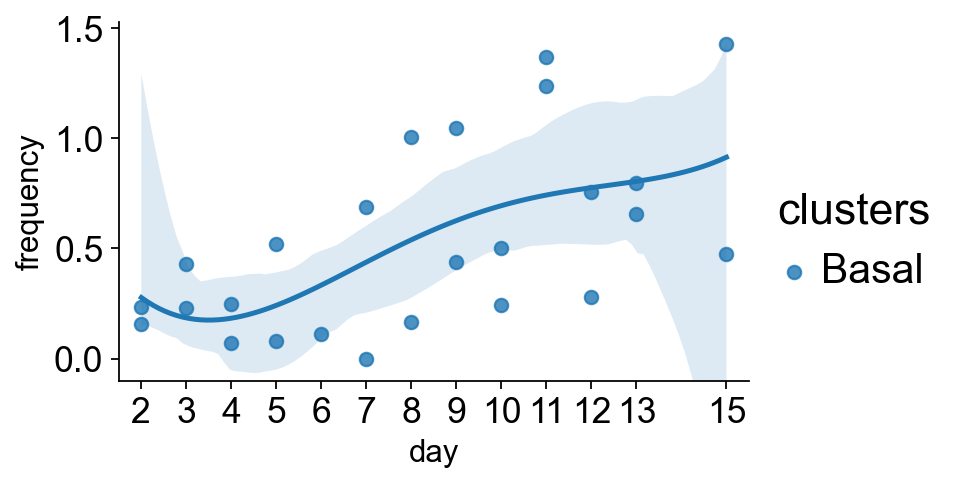

In [31]:
plot_frequency(adata, clusters=['Basal'], 
               save = FIG_DIR / "suppl_figures_lung" / "suppl_fig_goblet_to_basal" / "basal_frequency.pdf" 
               if save_figure else None)

## Compute a circular projection

Circular projection, summarising the fate probabilities towards all terminal states simulateneously. 

Solving TSP for `9` states


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


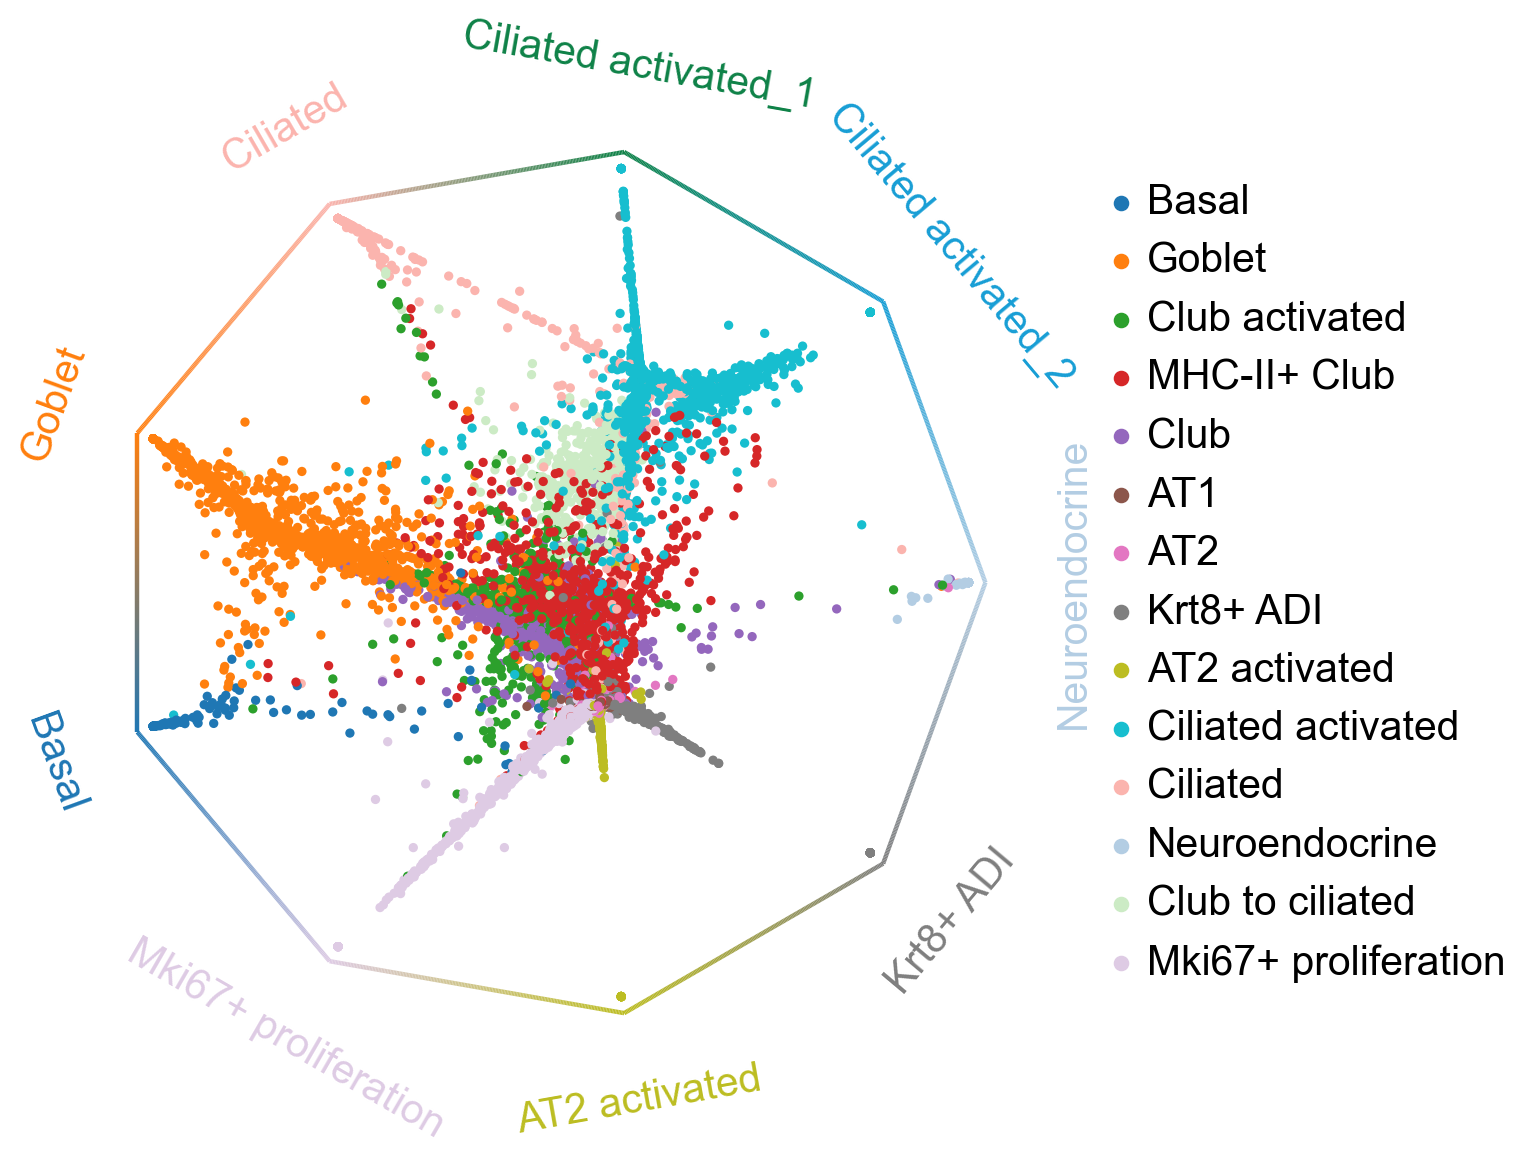

In [32]:
cr.pl.circular_projection(adata, keys=['clusters'], 
                          legend_loc='right', figsize=(40, 40), title='', normalize_by_mean=True, s=70, 
                         save=FIG_DIR / "suppl_figures_lung" / "suppl_fig_circular_projection" / "circ_clusters.pdf" 
                          if save_figure else None)

# Apply CellRank to goblet/basal subset

## Subset to goblet & basal cells

In [33]:
selection = ["Goblet", "Basal"]
mask = np.in1d(adata.obs['clusters'], selection)
bdata = adata[mask].copy()

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Compute diffmap on the subset

Recompute KNN and embeddings

In [34]:
sc.pp.neighbors(bdata, random_state=0)

if 'X_diffmap' in bdata.obsm.keys():
    del bdata.obsm['X_diffmap']
    
if 'diffmap_evals' in bdata.uns.keys():
    del bdata.uns['diffmap_evals']

# load/comptue diffmap
sc.tl.diffmap(bdata)

computing neighbors
    using 'X_pca' with n_pcs = 70
    finished (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9814772  0.9647426  0.93117255 0.92362523 0.90775293
     0.8959037  0.8715536  0.852653   0.84098774 0.83682853 0.8272837
     0.8230472  0.8198391  0.81525403]
    finished (0:00:00)


Velocities projected onto this diffmap:

computing velocity embedding


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


    finished (0:00:00) --> added
    'velocity_diffmap', embedded velocity vectors (adata.obsm)
saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_lung/suppl_fig_palantir_pseudotime/diffmap_clusters.pdf


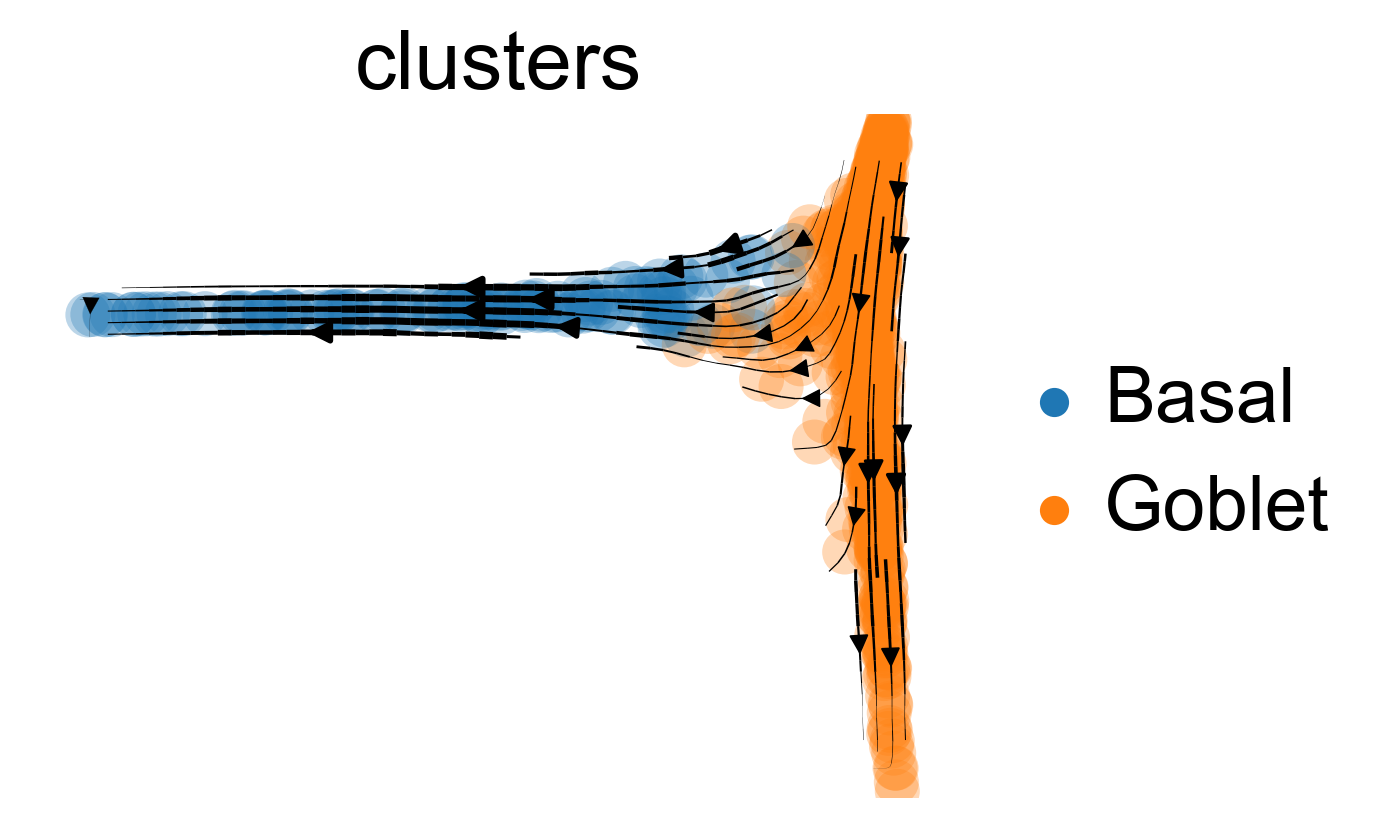

In [35]:
scv.pl.velocity_embedding_stream(bdata, 
                                 basis="diffmap", 
                                 color="clusters", 
                                 dpi=150, 
                                 figsize=(4, 3), 
                                 legend_loc='right', 
                                 save=scv.settings.figdir + "suppl_figures_lung/suppl_fig_palantir_pseudotime/diffmap_clusters.pdf" if save_figure else None)

## Check velocities on a per-gene level

Rank genes according to their likelihood value using scVelo's dynamical model for splicing kinetetics, grouped by cluster:

In [36]:
scv.tl.rank_dynamical_genes(bdata)
genes_goblet = bdata.uns['rank_dynamical_genes']['names']['Goblet']
genes_basal = bdata.uns['rank_dynamical_genes']['names']['Basal']
len(genes_goblet), len(genes_basal)

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ranking genes by cluster-specific likelihoods
    finished (0:00:00) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


(100, 100)

Define a gene set:

In [37]:
gene_set = ['Scgb1a1', 'Retnla', 'Bpifb1', 'Abi3bp', 'Muc5b', 'Muc5ac']

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Check where these genes rank in terms of their likeilhood value for the goblet cluster:

In [38]:
list_of_genes = genes_goblet
{gene: np.where(list_of_genes==gene)[0][0] if gene in list_of_genes else None for gene in gene_set}

{'Scgb1a1': 1,
 'Retnla': 9,
 'Bpifb1': 21,
 'Abi3bp': None,
 'Muc5b': 58,
 'Muc5ac': 44}

Same for the basal cluster:

In [39]:
list_of_genes = genes_basal
{gene: np.where(list_of_genes==gene)[0][0] if gene in list_of_genes else None for gene in gene_set}

{'Scgb1a1': None,
 'Retnla': None,
 'Bpifb1': None,
 'Abi3bp': 26,
 'Muc5b': None,
 'Muc5ac': 97}

Show splicing kinetics in phase space for some of these top-lilelihood genes:

saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_lung/suppl_fig_goblet_to_basal/phase_portraits_by_cluster.pdf


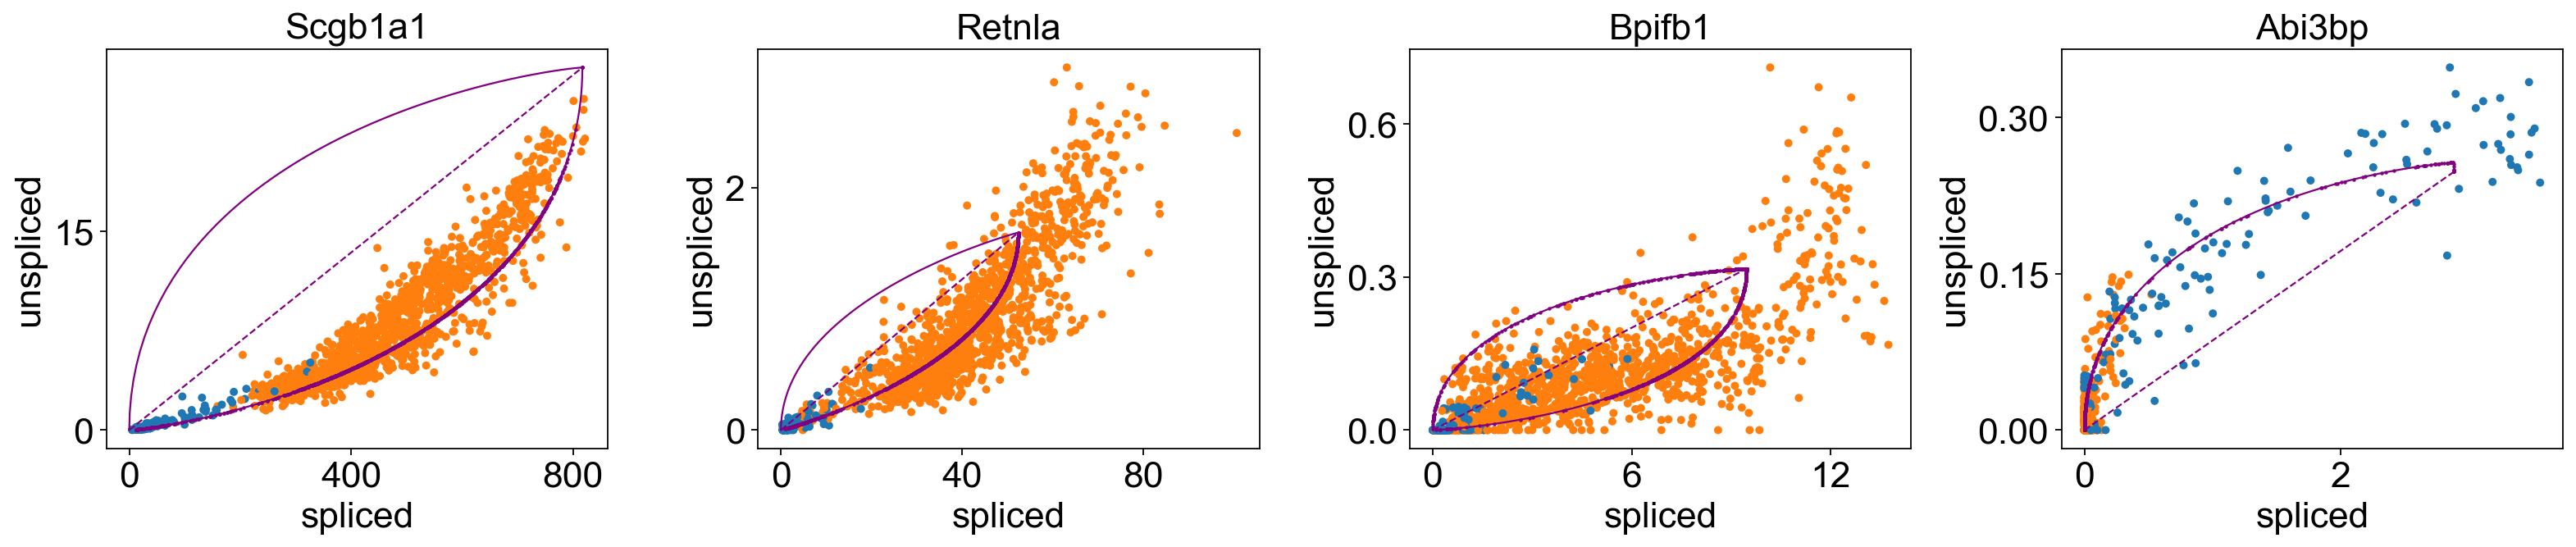

In [40]:
kwargs = dict(basis=gene_set[:4], size=80, legend_loc='none', wspace=0.3)

scv.pl.scatter(bdata, color='clusters', 
               save= scv.settings.figdir + "suppl_figures_lung/suppl_fig_goblet_to_basal/phase_portraits_by_cluster.pdf" if save_figure else None,
               **kwargs)

## Initialise kernel and estimator

We do this so that we can easily define the starting point of this process as well. 

In [41]:
if use_caching:
    c.tl.transition_matrix(bdata, 
                           weight_connectivities=weight_connectivities, 
                           mode=mode, 
                           n_jobs=n_jobs, 
                           softmax_scale=softmax_scale, 
                           fname='2021-09-24_transition_matrix_stochastic_subset', 
                           force=force_recompute)
    g_red = GPCCA(bdata, obsp_key='T_fwd')
else:
    kernel = cr.tl.transition_matrix(bdata, 
                                     weight_connectivities=weight_connectivities, 
                                     mode=mode, 
                                     n_jobs=n_jobs, 
                                     softmax_scale=softmax_scale)
    g_red = GPCCA(kernel)
    
print(g_red)

Loading data from: `2021-09-24_transition_matrix_stochastic_subset.pickle`.
`adata.obsp` already contains key: `'T_fwd'`.
`adata.uns` already contains key: `'T_fwd_params'`.
GPCCA[n=1239, kernel=<PrecomputedKernel[origin=adata.obsp['T_fwd']]>]


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Print transition matrix statistics for reproducibility

To make sure that we're using the same transition matrix, show some stats. 

In [42]:
# just for consistency, display some summary staes about the transition matrix
T = bdata.obsp['T_fwd']
T_med, T_mean, T_var = np.median(T.data), np.mean(T.data), np.var(T.data)
T_min, T_max = np.min(T.data), np.max(T.data)

print(f'med = {T_med:.6f},\nmean = {T_mean:.6f},\nvar = {T_var:.6f},\nmin = {T_min:.6f},\nmax = {T_max:.6f}')

med = 0.031346,
mean = 0.040826,
var = 0.001110,
min = 0.002228,
max = 0.300693


## Compute the real Schur decomposition

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


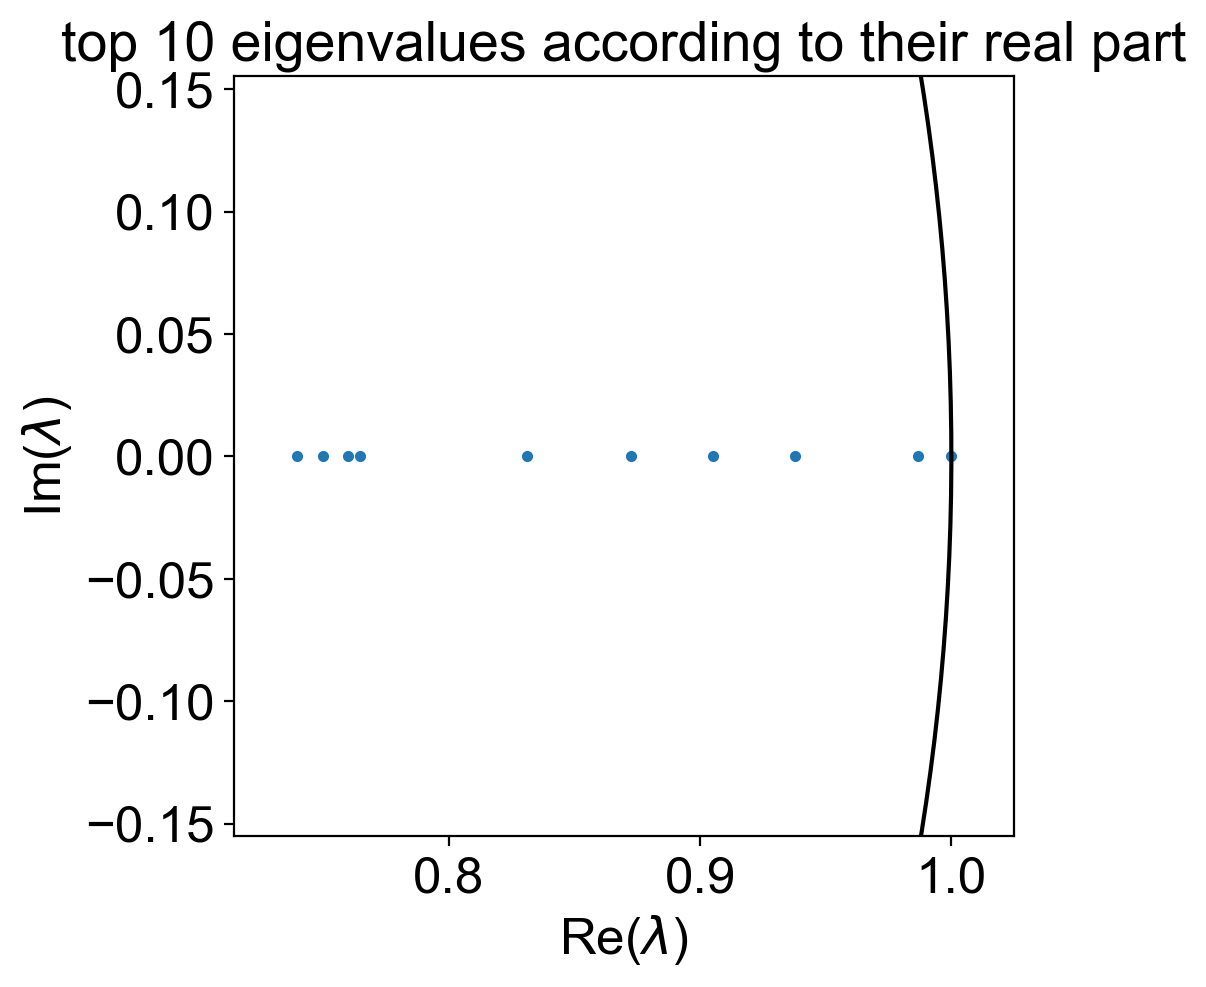

In [43]:
g_red.compute_schur()
g_red.plot_spectrum()

## Decompose into macrostates 

Computing `3` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_lung/suppl_fig_palantir_pseudotime/diffmap_macrostates.pdf


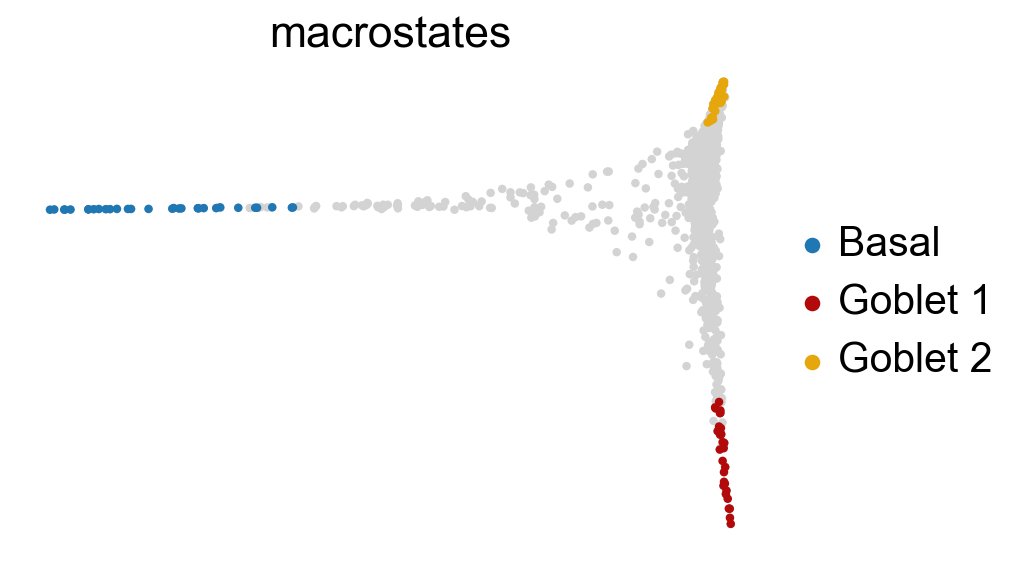

In [44]:
g_red.compute_macrostates(cluster_key='clusters', n_states=3)

fig_kwargs = {'basis': 'diffmap', 'discrete': True, 'legend_loc': 'right'}
if save_figure: fig_kwargs['save'] = scv.settings.figdir + 'suppl_figures_lung/suppl_fig_palantir_pseudotime/diffmap_macrostates.pdf'
g_red.plot_macrostates(**fig_kwargs)

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


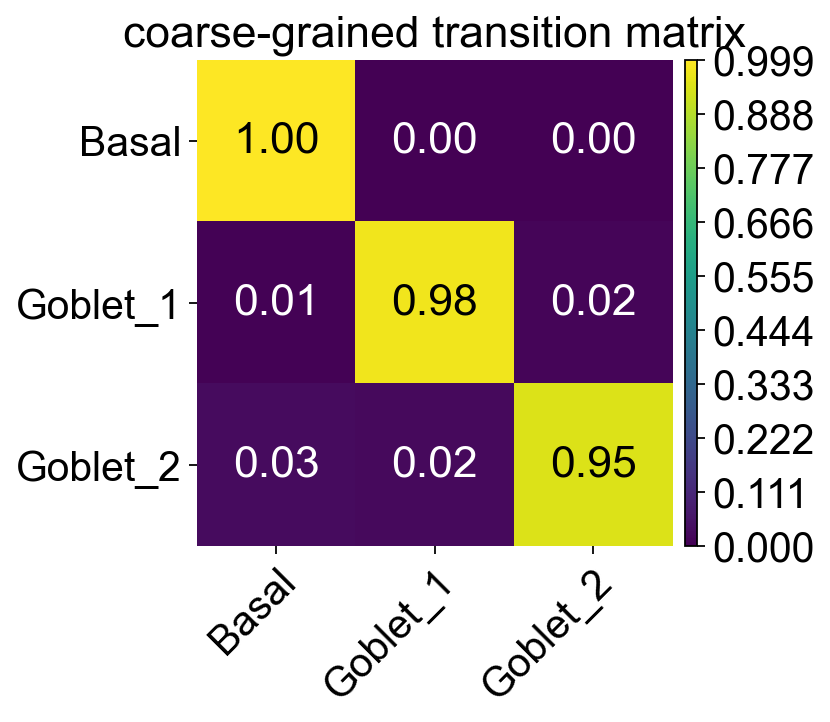

In [45]:
fig_kwargs = {'show_stationary_dist': False, 'figsize': (4, 4), 'annotate': True}
if save_figure: fig_kwargs['save'] = 'suppl_figures_lung/suppl_fig_palantir_pseudotime/heatmap_t_coarse.pdf'
g_red.plot_coarse_T(**fig_kwargs)

## Automatically identify initial and terminal states

Based on this, automatically determine the initial & terminal states:

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Adding `adata.obs['initial_states']`
       `adata.obs['initial_states_colors']`



/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_lung/suppl_fig_palantir_pseudotime/diffmap_initial.pdf


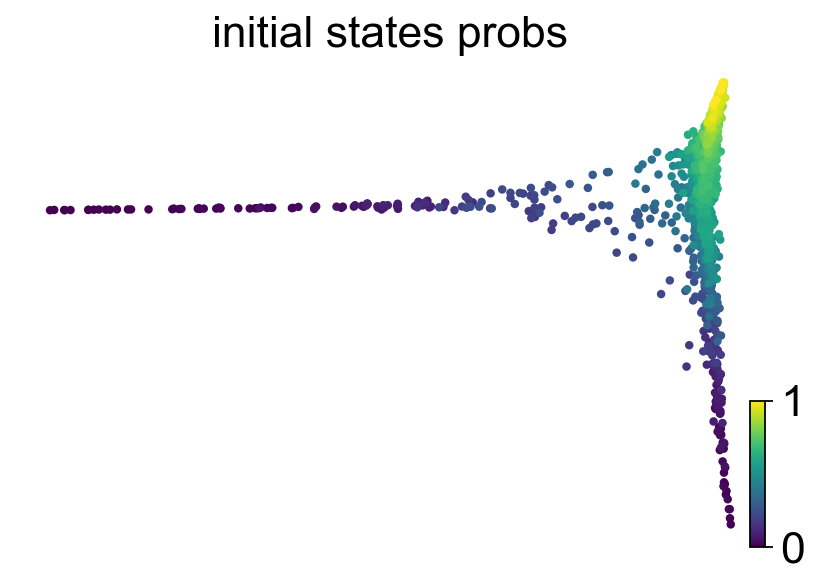

In [46]:
g_red.compute_terminal_states()
g_red._compute_initial_states()

fig_kwargs = {'color': 'initial_states_probs', 'basis': 'diffmap', 'legend_loc': 'right', 
              'color_map': 'viridis'}
if save_figure: fig_kwargs['save'] = scv.settings.figdir + 'suppl_figures_lung/suppl_fig_palantir_pseudotime/diffmap_initial.pdf'
scv.pl.scatter(bdata, **fig_kwargs)

Visualize the terminal states. 

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


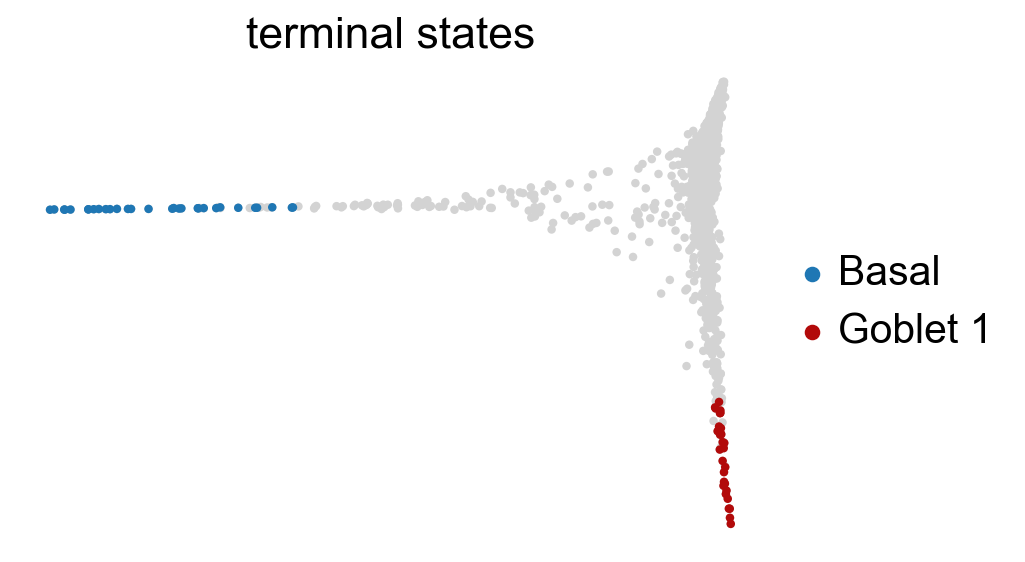

In [47]:
g_red.plot_terminal_states(basis='diffmap', discrete=True, legend_loc='right')

## Compute fate probabilities

Comptue absorption probabilities towards the terminal states

Computing absorption probabilities


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/2 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)


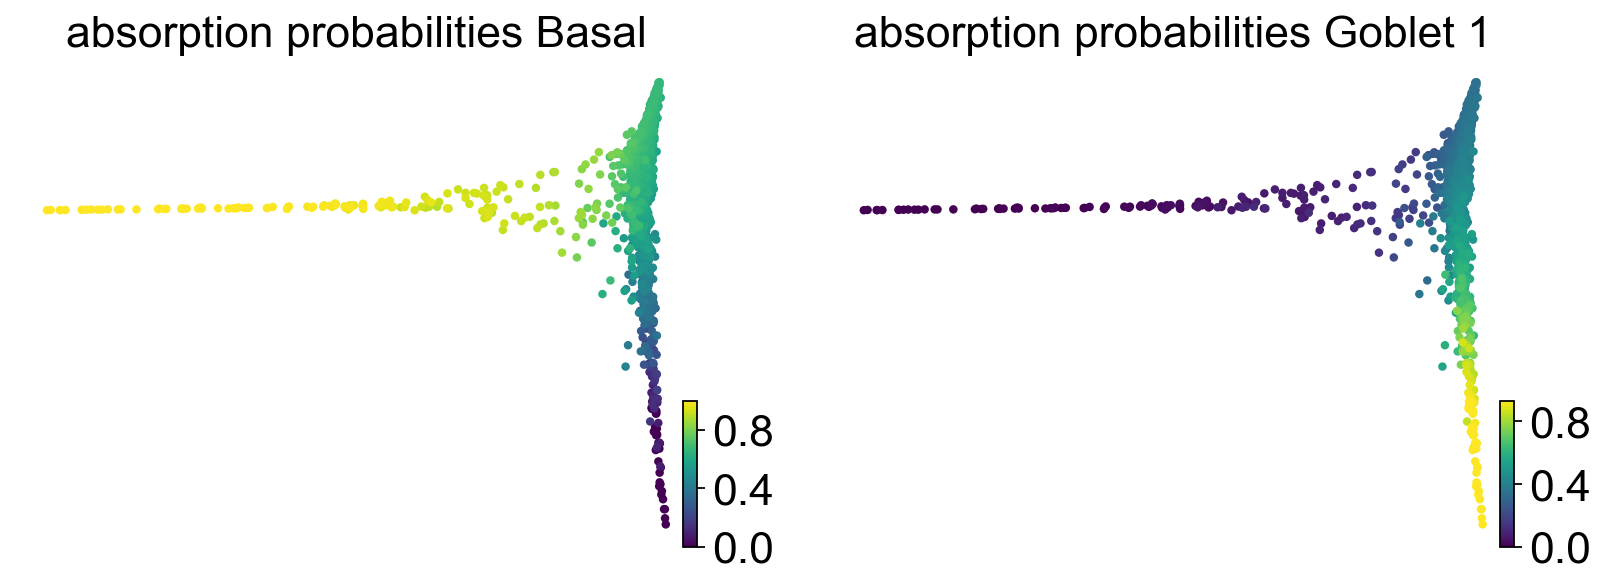

In [48]:
g_red.compute_absorption_probabilities()
g_red.plot_absorption_probabilities(basis='diffmap', same_plot=False)

## Run Palantir

In [49]:
import palantir

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Print the palantir version

In [50]:
print(f"palantir=={palantir.__version__}")

palantir==1.0.0


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Prepare the data, compute diffusion maps, multiscale data and actually run palantir

In [51]:
# compute diffusion map
n_comps = 300
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(bdata.obsm['X_pca'][:, :n_comps], index=bdata.obs_names))

# comptue multiscale space in diffusion map space
ms_data = palantir.utils.determine_multiscale_space(dm_res)

# run MAGIC imputation
imp_df = palantir.utils.run_magic_imputation(bdata, dm_res)

Determing nearest neighbor graph...
computing neighbors
    finished (0:00:00)


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


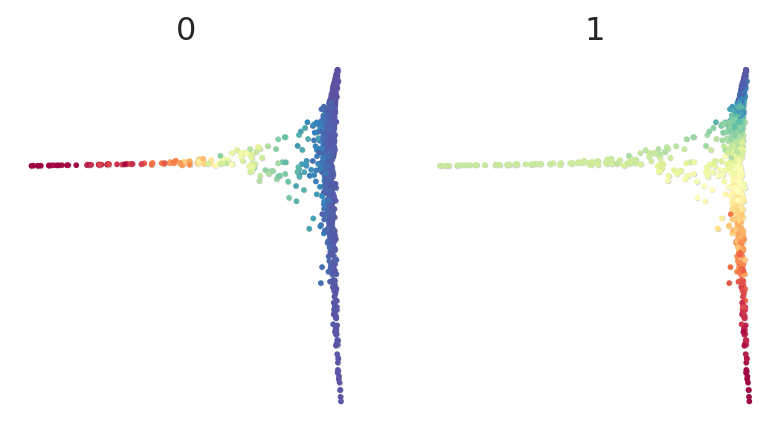

In [52]:
# look at these multiscale components
diffmap = pd.DataFrame(bdata.obsm['X_diffmap'][:, 1:3], index=bdata.obs_names, columns=['x', 'y'])

palantir.plot.plot_gene_expression(ms_data, diffmap, ms_data.columns)

Use CellRank to assign initial and terminal cells automatically. 

(<Figure size 320x320 with 1 Axes>, <AxesSubplot:>)

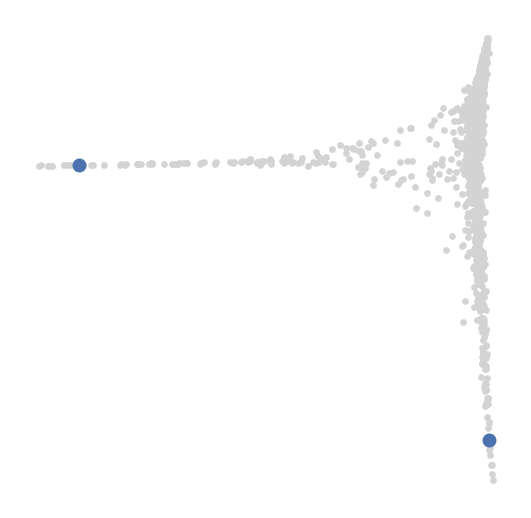

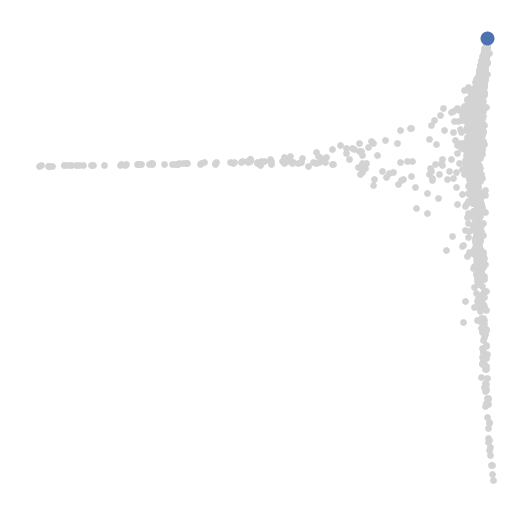

In [53]:
terminal_cells = {'Goblet': bdata[np.where(bdata.obs['terminal_states_probs'] == 1)[0]].obs_names[0],
               'Basal': bdata[np.where(bdata.obs['terminal_states_probs'] == 1)[0]].obs_names[1]
               }
initial_cell = bdata[bdata.obs['initial_states_probs'].argmax()].obs_names[0]

# show these initial and temrinal cells in an embedding
palantir.plot.highlight_cells_on_tsne(diffmap, terminal_cells.values()) # terminal
palantir.plot.highlight_cells_on_tsne(diffmap, initial_cell) # initial

Actually run Palantir

In [54]:
import random
random.seed = 0
np.random.seed(0)

pr_res = palantir.core.run_palantir(ms_data, 
                                    initial_cell, 
                                    terminal_states=terminal_cells.values(),
                                    knn=30, 
                                    num_waypoints=1200, 
                                    n_jobs=1,
                                    scale_components=False, 
                                    use_early_cell_as_start=True)

# Give the branches nice names
terminal_cells_inverse = {value: key for key, value in terminal_cells.items()}
pr_res.branch_probs.columns = [terminal_cells_inverse[key] for key in pr_res.branch_probs.columns]
pr_res.branch_probs.head()

# save both pseudotime and imputed data in bdata
bdata.obs['palantir_pseudotime'] = pr_res.pseudotime.copy()
bdata.layers['magic_imputed_data'] = imp_df.values

Sampling and flocking waypoints...
Time for determining waypoints: 0.004506317774454752 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.041904616355896 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [55]:
fig_kwargs = {'color': 'palantir_pseudotime', 
              'color_map': 'viridis', 
              'dpi': 150, 
              'basis': 'diffmap'}
if save_figure: fig_kwargs['save'] = scv.settings.figdir + 'suppl_figures_lung/suppl_fig_palantir_pseudotime/diffmap_pseudotime.pdf'
scv.pl.scatter(bdata, **fig_kwargs)

saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_lung/suppl_fig_palantir_pseudotime/diffmap_pseudotime.pdf


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/plotting/utils.py:1009: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


## Chart the stages of dedifferentiation

Define thresholds for the three stages of de-differentiation using pseudotime and CellRank's basal probability.

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


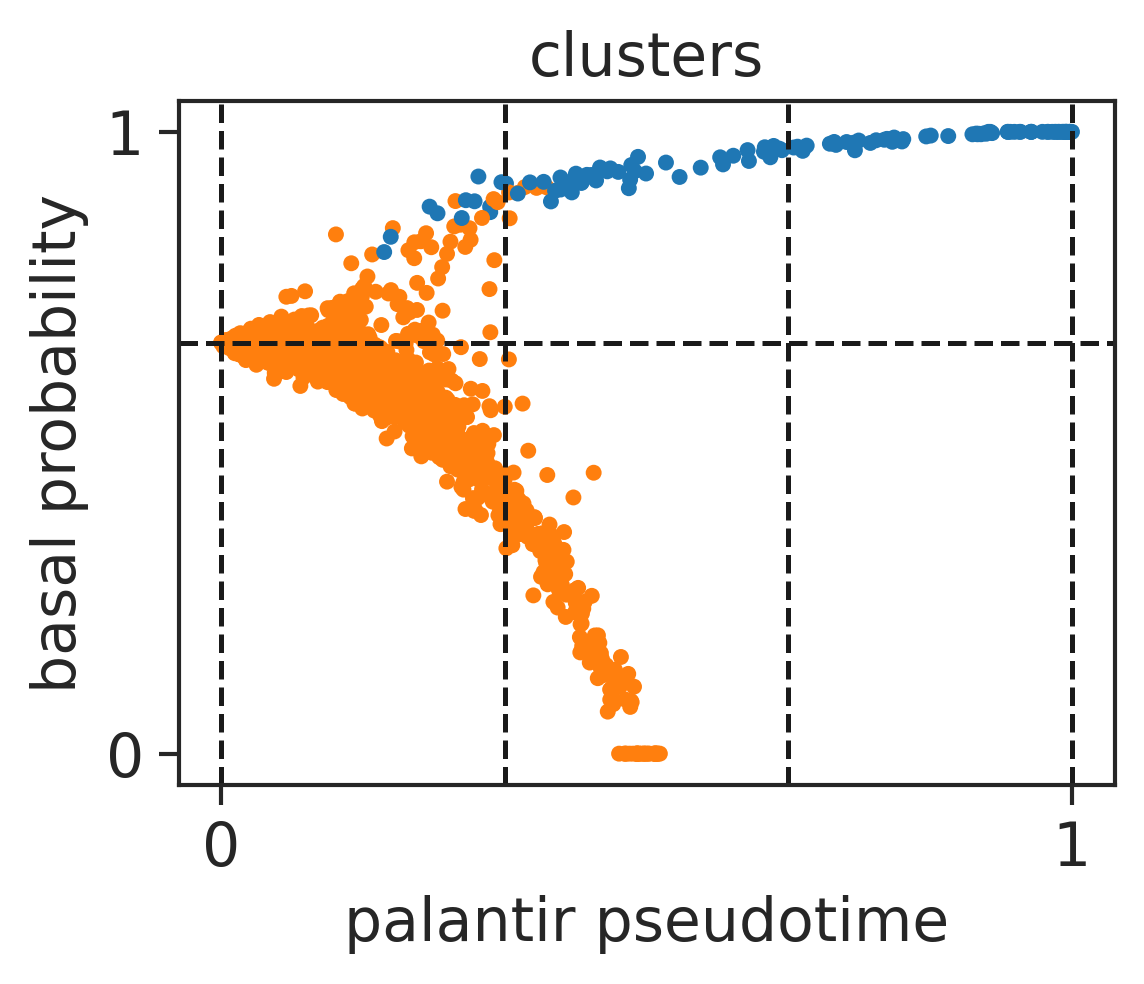

In [56]:
# copy into `.obs`
bdata.obs['basal_probability'] = bdata.obsm['to_terminal_states']['Basal'].X.flatten()
bdata.obs['goblet_probability'] = bdata.obsm['to_terminal_states']['Goblet_1'].X.flatten()

# divide the x-axis in three equal sized bins
basal_min, l1, l2 = 0.66, 1/3, 2/3 

fig = plt.figure(None, (4, 3), dpi=150)
ax = fig.add_subplot(111)

ax = scv.pl.scatter(bdata, x='palantir_pseudotime', y="basal_probability", show=False, ax=ax, color='clusters')
ax.axhline(y=basal_min, ls='--', c="k")
ax.axvline(x=0, ls='--', c="k")
ax.axvline(x=l1, ls='--', c="k")
ax.axvline(x=l2, ls='--', c="k")
ax.axvline(x=1, ls='--', c="k")

if save_figure:
    plt.savefig(FIG_DIR / "fig_6_lung" / "stages_of_dediff.pdf", bbox_inches='tight')

Use these thresholds to actually define the three stages

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-57-006e05cf323b>:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stage = pd.Series(index=bdata.obs_names)
/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/plotting/utils.py:643: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return n

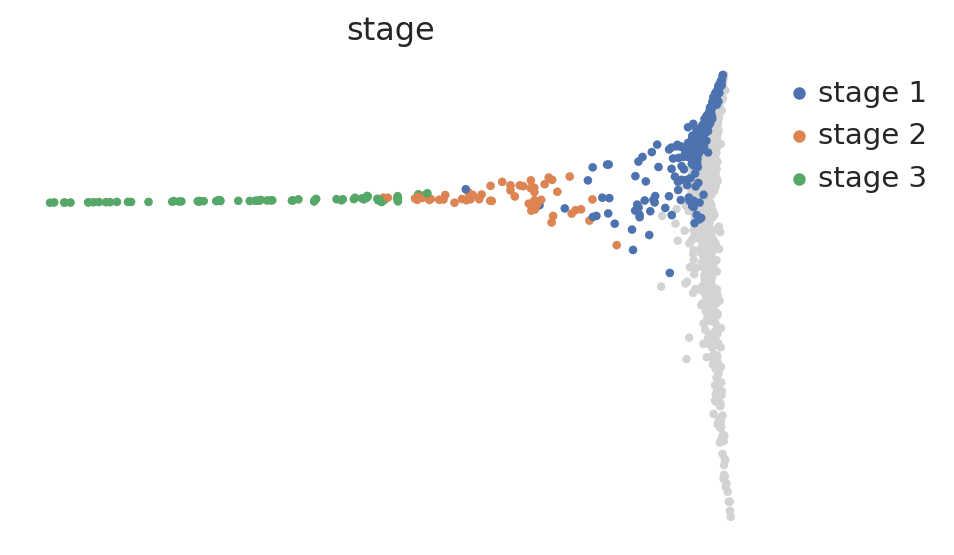

In [57]:
pseudotime = 'palantir_pseudotime'

# define the three stages
mask_1 = bdata.obs['basal_probability'] >= basal_min
mask_2 = bdata.obs[pseudotime] <= l1
mask_stage_1 = np.logical_and(mask_1, mask_2)

mask_1 = bdata.obs['basal_probability'] >= basal_min
mask_2 = bdata.obs[pseudotime] > l1
mask_3 = bdata.obs[pseudotime] <= l2
mask_4 = np.logical_and(mask_1, mask_2)
mask_stage_2 = np.logical_and(mask_4, mask_3)

mask_1 = bdata.obs['basal_probability'] >= basal_min
mask_2 = bdata.obs[pseudotime] >= l2
mask_stage_3 = np.logical_and(mask_1, mask_2)

# Use the masks to define a categorical annotation of the three stages
stage = pd.Series(index=bdata.obs_names)
stage[mask_stage_1] = "stage 1"
stage[mask_stage_2] = "stage 2"
stage[mask_stage_3] = "stage 3"
stage = stage.astype("category")
bdata.obs['stage'] = stage

# plot the categorical annotation
scv.pl.scatter(bdata, c='stage', basis='diffmap')

## Characterize the three stages

Show expression of key basal and goblet markers across the three stages in a dotplot:

In [58]:
sc.settings.figdir = FIG_DIR / "fig_6_lung"
sc.pl.dotplot(bdata, var_names=['Bpifb1', 'Krt5', 'Trp63'], groupby="stage", 
             save='stages.pdf' if save_figure else None)

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/scanpy/plotting/_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()
